THE SCHEDULING PROBLEM

In [1]:
import numpy as np
from qiskit.quantum_info import SparsePauliOp
from itertools import product
import matplotlib.pyplot as plt


# Define identity and Z matrices as Pauli strings
Z = 'Z'
I = 'I'

# Function to generate SparsePauliOp
def kronecker_product(operators, coeff, N):
    # Construct the Pauli string by joining the operators
    pauli_string = ''.join(operators)

    # Create the SparsePauliOp with the given coefficient
    return SparsePauliOp.from_list([(pauli_string, coeff)], num_qubits=N)

In [2]:
#Object oriented problem statement:
class scheduling_problem():
    def __init__(self, M, J, E, run_times):
        self.M = M
        self.J = J
        self.E = E
        self.run_times = run_times
        self.T = np.sum(run_times)
    
    #Needs to define hamiltonian
    def get_hamiltonian():
        pass

######

class seperate_index_scheduling_problem(scheduling_problem):
    def __init__(self, M, J, E, run_times):
        super().__init__(M,J,E,run_times)

        #Setup: add dummy index
        self.J = self.J + 1 #Adding the dummy node
        self.T = self.T + 1 #Adding time for dummy job
        #The last j is the dummy job
        self.run_times = self.run_times + [0]
        self.E += [(i, self.J-1) for i in range(self.J-1)] #Adding edges from the jobs to the dummy
        self.num_qubits = self.M * self.J * self.T
        self.term = SparsePauliOp.from_list([], num_qubits=self.num_qubits)

    #Function to access the qubit from its m,j,t index
    #@params
    # @@@ m - machine index
    # @@@ j - job index
    # @@@ t - time index
    def get_indicator_index(self, m, j, t):
        return m + self.M * j + self.M * self.J * t

    #Adds the QUBO term: x_(m,j,t) * x_(m',j',t') -> (1-a)*(1-b)-> -a-b+ab
    def binary_condition(self, m,j,t, m_tag, j_tag, t_tag, penalty_coeff):
        #Negative Linear terms
        operators = [I] * self.num_qubits
        operators[self.get_indicator_index(m,j,t)] = Z
        self.term += kronecker_product(operators, -1 * penalty_coeff, self.num_qubits)

        operators = [I] * self.num_qubits
        operators[self.get_indicator_index(m_tag,j_tag,t_tag)] = Z
        self.term += kronecker_product(operators, -1 * penalty_coeff, self.num_qubits)
        
        #Positive Square terms
        operators = [I] * self.num_qubits
        operators[self.get_indicator_index(m,j,t)] = Z
        operators[self.get_indicator_index(m_tag,j_tag,t_tag)] = Z
        self.term += kronecker_product(operators, penalty_coeff, self.num_qubits)

    #####
    def H_no_parallel_execution(self, penalty_coeff):
        #Loop through all combinations that need Z:
        for m in range(self.M):
            for j in range(self.J):
                for j_tag in range(j+1, self.J): #Pairs
                    for t in range(self.T):
                        for t_tag in range(t, min(t + self.run_times[j], self.T)): #Note - it is not run_times[j] - 1, since range doesn't include the edge 
                            self.binary_condition(m,j,t, m, j_tag, t_tag, penalty_coeff)

    def H_dependency(self, penalty_coeff):
        for (j,j_tag) in self.E:
            for m in range(self.M):
                for m_tag in range(self.M):
                    for t in range(self.T):
                        for t_tag in range(0, min(t + self.run_times[j], self.T)): #Note - run_times[j] - 1 
                            self.binary_condition(m,j,t, m_tag, j_tag, t_tag, penalty_coeff)

    def H_force_run(self, penalty_coeff): #Force every job to run once.
        ###

        for j in range(self.J):
            for m in range(self.M):
                for t in range(self.T):
                    operators = [I] * self.num_qubits
                    operators[self.get_indicator_index(m,j,t)] = Z
                    self.term += kronecker_product(operators, (1 - self.M * self.T / 2) * penalty_coeff, self.num_qubits)

            for m in range(self.M):
                for m_tag in range(self.M):
                    for t in range(self.T):
                        for t_tag in range(t, self.T): #need to multiply the coeff
                            if(t == t_tag and m == m_tag): #Only in this case we can skip
                                continue
                            operators = [I] * self.num_qubits
                            operators[self.get_indicator_index(m,j,t)] = Z
                            operators[self.get_indicator_index(m_tag,j,t_tag)] = Z
                            self.term += kronecker_product(operators, 0.5 * penalty_coeff, self.num_qubits)

    def H_finish_time(self):
        #Loop through all combinations that need Z:
        j_dummy = self.J - 1

        #Score for adding the dummy job on any machine
        for t in range(self.T):
            for m in range(self.M):
                    operators = [I] * self.num_qubits
                    operators[self.get_indicator_index(m,j_dummy,t)] = Z
                    self.term += kronecker_product(operators, (-1) * t, self.num_qubits)

        
    def get_hamiltonian(self, penalty_coeff):
        self.term = SparsePauliOp.from_list([], num_qubits=self.num_qubits)
        #All conditions
        self.H_no_parallel_execution(penalty_coeff)
        self.H_dependency(penalty_coeff)
        self.H_force_run(penalty_coeff)
        self.H_finish_time()

        return self.term
    
    def print_solution(self, binary_solution):
        print("Quantum State (computational basis):", '|' + binary_solution + '>')
        print("===Solution===")
        for t in range(self.T):
            for j in range(self.J):
                for m in range(self.M):
                    if(binary_solution[self.get_indicator_index(m,j,t)] == '1'):
                        print(f"t={t}: Job #{j if j != self.J-1 else 'dummy'} -> Machine #{m}")
        print("===end===")

    def print_problem(self):
        print("===Problem===")
        print(f"Run {self.J - 1}(+1 dummy) jobs on {self.M} machines.")
        print(f"Job Lengths: {self.run_times}")
        print(f"Dependency Graph {self.E}")
        print("===")

In [3]:
class seperate_index_full_values_scheduling_problem(scheduling_problem):
    #Represents the full hamiltonian without constants dropped out
    def __init__(self, M, J, E, run_times):
        super().__init__(M,J,E,run_times)

        #Setup: add dummy index
        self.J = self.J + 1 #Adding the dummy node
        self.T = self.T + 1 #Adding time for dummy job
        #The last j is the dummy job
        self.run_times = self.run_times + [0]
        self.E += [(i, self.J-1) for i in range(self.J-1)] #Adding edges from the jobs to the dummy
        self.num_qubits = self.M * self.J * self.T

    #Function to access the qubit from its m,j,t index
    def get_indicator_index(self, m, j, t):
        return m + self.M * j + self.M * self.J * t

    #Adds the QUBO term: x_(m,j,t) * x_(m',j',t') -> 0.25(1-a)*(1-b)-> 0.25(1-a-b+ab)
    def binary_condition(self, m,j,t, m_tag, j_tag, t_tag, penalty_coeff):
        term = SparsePauliOp.from_list([], num_qubits=self.num_qubits)
        #Identity term
        operators = [I] * self.num_qubits
        term += kronecker_product(operators, 0.25 * penalty_coeff, self.num_qubits)

        #Negative Linear terms
        operators = [I] * self.num_qubits
        operators[self.get_indicator_index(m,j,t)] = Z
        term += kronecker_product(operators, -0.25 * penalty_coeff, self.num_qubits)

        operators = [I] * self.num_qubits
        operators[self.get_indicator_index(m_tag,j_tag,t_tag)] = Z
        term += kronecker_product(operators, -0.25 * penalty_coeff, self.num_qubits)
        
        #Positive Square terms
        operators = [I] * self.num_qubits
        operators[self.get_indicator_index(m,j,t)] = Z
        operators[self.get_indicator_index(m_tag,j_tag,t_tag)] = Z
        term += kronecker_product(operators, 0.25*penalty_coeff, self.num_qubits)

        return term

    #####
    def H_no_parallel_execution(self, penalty_coeff):
        term = SparsePauliOp.from_list([], num_qubits=self.num_qubits)
        
        for m in range(self.M):
            for j in range(self.J):
                for j_tag in range(j+1, self.J): #Pairs
                    for t in range(self.T):
                        for t_tag in range(t, min(t + self.run_times[j], self.T)): #Note - from t'=t because maybe the job finished way earlier
                            term += self.binary_condition(m,j,t, m, j_tag, t_tag, penalty_coeff)
                            #print(f"(m,j,t)={(m,j,t)},(m',j',t')={(m,j_tag,t_tag)}")
        return term

    def H_dependency(self, penalty_coeff):
        term = SparsePauliOp.from_list([], num_qubits=self.num_qubits)
        
        for (j,j_tag) in self.E:
            for m in range(self.M):
                for m_tag in range(self.M):
                    for t in range(self.T):
                        for t_tag in range(0, min(t + self.run_times[j], self.T)): #Note - from t'=0 because it cannot happen before j
                            #print(f"#dep: {(m,j,t)} & {(m_tag, j_tag, t_tag)}")
                            term += self.binary_condition(m,j,t, m_tag, j_tag, t_tag, penalty_coeff)
        return term

    def H_force_run(self, penalty_coeff): #Force every job to run once.
        term = SparsePauliOp.from_list([], num_qubits=self.num_qubits)
        
        for j in range(self.J):
            operators = [I] * self.num_qubits
            term += kronecker_product(operators, (1 - self.M * self.T / 2)*(1 - self.M * self.T / 2) * penalty_coeff, self.num_qubits)

            for m in range(self.M):
                for t in range(self.T):
                    operators = [I] * self.num_qubits
                    operators[self.get_indicator_index(m,j,t)] = Z
                    term += kronecker_product(operators, (1 - self.M * self.T / 2) * penalty_coeff, self.num_qubits)

            for m in range(self.M):
                for m_tag in range(self.M):
                    for t in range(self.T):
                        for t_tag in range(self.T):
                            operators = [I] * self.num_qubits
                            operators[self.get_indicator_index(m,j,t)] = Z
                            operators[self.get_indicator_index(m_tag,j,t_tag)] = Z
                            if(m == m_tag and t == t_tag):
                                operators[self.get_indicator_index(m_tag,j,t_tag)] = I

                            term += kronecker_product(operators, 0.25 * penalty_coeff, self.num_qubits)
                            #print(f"(m,j,t)={(m,j,t)},(m',j',t')={(m_tag,j,t_tag)}")
        return term

    def H_finish_time(self):
        term = SparsePauliOp.from_list([], num_qubits=self.num_qubits)
        j_dummy = self.J - 1

        #Score for adding the dummy job on any machine
        for t in range(self.T):
            for m in range(self.M):
                    operators = [I] * self.num_qubits
                    term += kronecker_product(operators, (0.5) * t, self.num_qubits)
                    
                    operators = [I] * self.num_qubits
                    operators[self.get_indicator_index(m,j_dummy,t)] = Z
                    term += kronecker_product(operators, (-0.5) * t, self.num_qubits)
        return term

        
    def get_hamiltonian(self, penalty_coeff):
        return self.H_no_parallel_execution(penalty_coeff) + self.H_dependency(penalty_coeff) + self.H_force_run(penalty_coeff) + self.H_finish_time()
    
    def print_solution(self, binary_solution):
        print("Quantum State (computational basis):", '|' + binary_solution + '>')
        print("===Solution===")
        for t in range(self.T):
            for j in range(self.J):
                for m in range(self.M):
                    if(binary_solution[self.get_indicator_index(m,j,t)] == '1'):
                        print(f"t={t}: Job #{j if j != self.J-1 else 'dummy'} -> Machine #{m}")
        print("===end===")

    def print_problem(self):
        print("===Problem===")
        print(f"Run {self.J - 1}(+1 dummy) jobs on {self.M} machines.")
        print(f"Job Lengths: {self.run_times}")
        print(f"Dependency Graph {self.E}")
        print("===")

In [4]:
class xy_method_base_scheduling_problem(scheduling_problem):
    def __init__(self, M, J, E, run_times):
        super().__init__(M,J,E,run_times)

        #Setup: add dummy index
        self.J = self.J + 1 #Adding the dummy node
        self.T = self.T + 1 #Adding time for dummy job
        #The last j is the dummy job
        self.run_times = self.run_times + [0]
        self.E += [(i, self.J-1) for i in range(self.J-1)] #Adding edges from the jobs to the dummy
        self.num_qubits = self.M * self.J + self.T * self.J

        self.term = SparsePauliOp.from_list([], num_qubits=self.num_qubits)

    #X_(m,j) and Y_(t,j) are two binary vectors appended together
    def X_get_indicator_index(self, m, j, t):
        return m + self.M * j
    
    def Y_get_indicator_index(self, m, j, t):
        return self.M * self.J + j + self.J * t #Y occurs after all of X

    #Adds the QUBO term: x_(m,j,t) * x_(m',j',t')
    #Note that x_(m,j,t) = X_(m,j) * Y_(t,j) so the expansion is different
    #-> (1-a)(1-b)(1-c)(1-d)-> -a-b-c-d+ab+bc+cd+ad+ac+bd-abc-bcd-cda-dba+abcd
    #a=X_m,j; b=Y_m,j; c=X_m',j'; d=Y_m',j'
    def binary_condition(self, m,j,t, m_tag, j_tag, t_tag, penalty_coeff):
        a = self.X_get_indicator_index(m,j,t)
        b = self.Y_get_indicator_index(m,j,t)
        c = self.X_get_indicator_index(m_tag,j_tag,t_tag)
        d = self.Y_get_indicator_index(m_tag,j_tag,t_tag)
        
        #Negative Linear terms
        operators = [I] * self.num_qubits
        operators[a] = Z
        self.term += kronecker_product(operators, -1 * penalty_coeff, self.num_qubits)

        operators = [I] * self.num_qubits
        operators[b] = Z
        self.term += kronecker_product(operators, -1 * penalty_coeff, self.num_qubits)
        
        operators = [I] * self.num_qubits
        operators[c] = Z
        self.term += kronecker_product(operators, -1 * penalty_coeff, self.num_qubits)

        operators = [I] * self.num_qubits
        operators[d] = Z
        self.term += kronecker_product(operators, -1 * penalty_coeff, self.num_qubits)

        #Positive Square terms
        operators = [I] * self.num_qubits
        operators[a] = Z
        operators[b] = Z
        self.term += kronecker_product(operators, penalty_coeff, self.num_qubits)

        operators = [I] * self.num_qubits
        operators[b] = Z
        operators[c] = Z
        self.term += kronecker_product(operators, penalty_coeff, self.num_qubits)

        operators = [I] * self.num_qubits
        operators[c] = Z
        operators[d] = Z
        self.term += kronecker_product(operators, penalty_coeff, self.num_qubits)

        operators = [I] * self.num_qubits
        operators[a] = Z
        operators[d] = Z
        self.term += kronecker_product(operators, penalty_coeff, self.num_qubits)

        operators = [I] * self.num_qubits
        operators[a] = Z
        operators[c] = Z
        self.term += kronecker_product(operators, penalty_coeff, self.num_qubits)

        operators = [I] * self.num_qubits
        operators[b] = Z
        operators[d] = Z
        self.term += kronecker_product(operators, penalty_coeff, self.num_qubits)

        #Negative cubic terms:
        operators = [I] * self.num_qubits
        operators[a] = Z
        operators[b] = Z
        operators[c] = Z
        self.term += kronecker_product(operators, -1 * penalty_coeff, self.num_qubits)

        operators = [I] * self.num_qubits
        operators[a] = Z
        operators[b] = Z
        operators[d] = Z
        self.term += kronecker_product(operators, -1 * penalty_coeff, self.num_qubits)

        operators = [I] * self.num_qubits
        operators[a] = Z
        operators[c] = Z
        operators[d] = Z
        self.term += kronecker_product(operators, -1 * penalty_coeff, self.num_qubits)

        operators = [I] * self.num_qubits
        operators[b] = Z
        operators[c] = Z
        operators[d] = Z
        self.term += kronecker_product(operators, -1 * penalty_coeff, self.num_qubits)

        #Positive quartic term:
        operators = [I] * self.num_qubits
        operators[a] = Z
        operators[b] = Z
        operators[c] = Z
        operators[d] = Z
        self.term += kronecker_product(operators, penalty_coeff, self.num_qubits)

    #####
    def H_no_parallel_execution(self, penalty_coeff):
        for m in range(self.M):
            for j in range(self.J):
                for j_tag in range(j+1, self.J): #Pairs
                    for t in range(self.T):
                        for t_tag in range(t, min(t + self.run_times[j], self.T)):
                            self.binary_condition(m,j,t, m, j_tag, t_tag, penalty_coeff)

    def H_dependency(self, penalty_coeff):
        for (j,j_tag) in self.E:
            for m in range(self.M):
                for m_tag in range(self.M):
                    for t in range(self.T):
                        for t_tag in range(0, min(t + self.run_times[j], self.T)):
                            self.binary_condition(m,j,t, m_tag, j_tag, t_tag, penalty_coeff)

    def H_force_run(self, penalty_coeff): #Force every job to run once.
        #if there is a bug, it is most of the time here :)
        for j in range(self.J):
            for m in range(self.M):
                for t in range(self.T):
                    operators = [I] * self.num_qubits
                    operators[self.X_get_indicator_index(m,j,t)] = Z
                    self.term += kronecker_product(operators, 0.5*(1 - self.M * self.T / 4) * penalty_coeff, self.num_qubits)
                    
                    operators = [I] * self.num_qubits
                    operators[self.Y_get_indicator_index(m,j,t)] = Z
                    self.term += kronecker_product(operators, 0.5*(1 - self.M * self.T / 4) * penalty_coeff, self.num_qubits)
                    
                    operators = [I] * self.num_qubits
                    operators[self.X_get_indicator_index(m,j,t)] = Z
                    operators[self.Y_get_indicator_index(m,j,t)] = Z
                    self.term += kronecker_product(operators, -1 * 0.5*(1 - self.M * self.T / 4) * penalty_coeff, self.num_qubits)

            #Quadratic terms:
            for m in range(self.M):
                for m_tag in range(self.M):
                    for t in range(self.T):
                        for t_tag in range(self.T):
                            if(m == m_tag and t == t_tag):
                                continue
                            #Quadratic terms: (x+y-xy)^2 -> xy' + x'y + xx' + yy'
                            operators = [I] * self.num_qubits
                            operators[self.X_get_indicator_index(m,j,t)] = Z
                            operators[self.Y_get_indicator_index(m_tag,j,t_tag)] = Z
                            self.term += kronecker_product(operators, 1/16 * penalty_coeff, self.num_qubits)

                            operators = [I] * self.num_qubits
                            operators[self.Y_get_indicator_index(m,j,t)] = Z
                            operators[self.X_get_indicator_index(m_tag,j,t_tag)] = Z
                            self.term += kronecker_product(operators, 1/16 * penalty_coeff, self.num_qubits)

                            operators = [I] * self.num_qubits
                            operators[self.X_get_indicator_index(m,j,t)] = Z
                            operators[self.X_get_indicator_index(m_tag,j,t_tag)] = Z
                            self.term += kronecker_product(operators, 1/16 * penalty_coeff, self.num_qubits)

                            operators = [I] * self.num_qubits
                            operators[self.Y_get_indicator_index(m,j,t)] = Z
                            operators[self.Y_get_indicator_index(m_tag,j,t_tag)] = Z
                            self.term += kronecker_product(operators, 1/16 * penalty_coeff, self.num_qubits)

                            #Cubic terms: -> -2x^2y-2xy^2
                            operators = [I] * self.num_qubits
                            operators[self.X_get_indicator_index(m,j,t)] = Z
                            operators[self.Y_get_indicator_index(m,j,t)] = Z
                            operators[self.X_get_indicator_index(m_tag,j,t_tag)] = Z
                            self.term += kronecker_product(operators, -1/16 * penalty_coeff, self.num_qubits)

                            operators = [I] * self.num_qubits
                            operators[self.X_get_indicator_index(m,j,t)] = Z
                            operators[self.Y_get_indicator_index(m,j,t)] = Z
                            operators[self.Y_get_indicator_index(m_tag,j,t_tag)] = Z
                            self.term += kronecker_product(operators, -1/16 * penalty_coeff, self.num_qubits)

                            #Quartic term xyx'y':
                            operators = [I] * self.num_qubits
                            operators[self.X_get_indicator_index(m,j,t)] = Z
                            operators[self.Y_get_indicator_index(m,j,t)] = Z
                            operators[self.X_get_indicator_index(m_tag,j,t_tag)] = Z
                            operators[self.Y_get_indicator_index(m_tag,j,t_tag)] = Z
                            self.term += kronecker_product(operators, 1/16 * penalty_coeff, self.num_qubits)

    def H_finish_time(self):
        #Loop through all combinations that need Z:
        j_dummy = self.J - 1

        #Score for adding the dummy job on any machine
        for t in range(self.T):
            for m in range(self.M):
                    #Term: X_m,j,t -> (1-a)(1-b) -> -a-b+ab, a=X_m,j ; b=Y_t,j
                    operators = [I] * self.num_qubits
                    operators[self.X_get_indicator_index(m,j_dummy,t)] = Z
                    self.term += kronecker_product(operators, (-1) * t, self.num_qubits)

                    operators = [I] * self.num_qubits
                    operators[self.Y_get_indicator_index(m,j_dummy,t)] = Z
                    self.term += kronecker_product(operators, (-1) * t, self.num_qubits)

                    operators = [I] * self.num_qubits
                    operators[self.X_get_indicator_index(m,j_dummy,t)] = Z
                    operators[self.Y_get_indicator_index(m,j_dummy,t)] = Z
                    self.term += kronecker_product(operators, t, self.num_qubits)

        
    def get_hamiltonian(self, penalty_coeff):
        self.term = SparsePauliOp.from_list([], num_qubits=self.num_qubits)
        #All conditions
        self.H_no_parallel_execution(penalty_coeff)
        self.H_dependency(penalty_coeff)
        self.H_force_run(penalty_coeff)
        self.H_finish_time()

        return self.term
    
    def print_solution(self, binary_solution):
        print("Quantum State (computational basis):", '|' + binary_solution + '>')
        
        print(f"M={self.M}, J={self.J}, T={self.T}")
        print(f"X={binary_solution[ : self.M*self.J]}, Y={binary_solution[self.M*self.J : ]}")

        print("===Solution===")
        for t in range(self.T):
            for j in range(self.J):
                for m in range(self.M):
                    if(binary_solution[self.X_get_indicator_index(m,j,t)] == '1' and binary_solution[self.Y_get_indicator_index(m,j,t)] == '1'):
                        print(f"t={t}: Job #{j if j != self.J-1 else 'dummy'} -> Machine #{m}")
        print("===end===")

    def print_problem(self):
        print("===Problem===")
        print(f"Run {self.J - 1}(+1 dummy) jobs on {self.M} machines.")
        print(f"Job Lengths: {self.run_times}")
        print(f"Dependency Graph {self.E}")
        print("===")

In [5]:
class xy_method_scheduling_problem(xy_method_base_scheduling_problem):
    def __init__(self, M, J, E, run_times):
        super().__init__(M,J,E,run_times)
    
    def H_force_run(self, penalty_coeff): #Force every job to run once.
        #New idea - seperately enforce the condition on X and on Y
        
        #For X #Only looks for machines
        for j in range(self.J):
            for m in range(self.M):
                operators = [I] * self.num_qubits
                operators[self.X_get_indicator_index(m,j,0)] = Z
                self.term += kronecker_product(operators, (1 - self.M / 2) * penalty_coeff, self.num_qubits)

            for m in range(self.M):
                for m_tag in range(m+1, self.M): #need to multiply the coeff
                        operators = [I] * self.num_qubits
                        operators[self.X_get_indicator_index(m,j,None)] = Z
                        operators[self.X_get_indicator_index(m_tag,j,None)] = Z
                        self.term += kronecker_product(operators, 0.5 * penalty_coeff, self.num_qubits)
        
        #For Y
        for j in range(self.J):
            for t in range(self.T):
                operators = [I] * self.num_qubits
                operators[self.Y_get_indicator_index(None,j,t)] = Z
                self.term += kronecker_product(operators, (1 - self.T / 2) * penalty_coeff, self.num_qubits)

            for t in range(self.T):
                for t_tag in range(t+1, self.T): #need to multiply the coeff
                    operators = [I] * self.num_qubits
                    operators[self.Y_get_indicator_index(None,j,t)] = Z
                    operators[self.Y_get_indicator_index(None,j,t_tag)] = Z
                    self.term += kronecker_product(operators, 0.5 * penalty_coeff, self.num_qubits)

In [6]:
# Define a sample problem
#Note, the last job is the dummy job
#M = 2
#J = 3
#E = [(0, 2), (1,2)]
#run_times = np.array([1,2,1])

#### TEST 0 - 4 qubits PASSED
M = 2
J = 1
E = []
run_times = np.array([1])
####

#### TEST 1 - 9 qubits PASSED
#M = 1
#J = 2
#E = [(0,1)]
#run_times = np.array([1,1])
####

#### TEST 2 - 18 qubits PASSED
#M = 2
#J = 2
#E = [(1,0), (2,1)]
#run_times = np.array([1,1,0])
####

#seperate_index_full_values_scheduling_problem vs seperate_index_scheduling_problem vs xy_method_scheduling_problem
task = seperate_index_full_values_scheduling_problem(M, J, E, run_times)

#print(task.X_get_indicator_index(0,1,1))
#print(task.Y_get_indicator_index(0,0,0))

penalty_coeff = 100

print(f"Solver: {type(task)}")
print(f"Used {task.num_qubits} qubits")
H_total_JSP = task.get_hamiltonian(penalty_coeff)

Solver: <class '__main__.seperate_index_full_values_scheduling_problem'>
Used 8 qubits


In [7]:
import numpy as np

def kronker_vector_to_binary(vector):
    # Find the index of the non-zero element
    index = np.argmax(vector)
    
    # Convert the index to binary representation
    n = int(np.log2(len(vector)))  # Calculate the number of qubits
    binary_representation = format(index, f'0{n}b')  # Format index as binary with leading zeros
    
    # Create the quantum state string
    quantum_state = ''.join(binary_representation)
    
    return quantum_state

import itertools
def generate_binary_vectors(n):
    for vector in itertools.product([0, 1], repeat=n): #of Z eigenvalues
        yield np.array(vector)

def generate_one_hot_vectors(n):
    for i in range(n):
        vector = [0] * n  # Create a vector of zeros
        vector[i] = 1     # Set the i-th position to 1
        yield np.array(vector).reshape((n, 1)) # Yield the one-hot vector

def binary_to_kronker(binary_string):
    n = len(binary_string)
    # Convert binary string to decimal
    decimal_index = int(binary_string, 2)
    # Create a one-hot encoded vector of size 2^n
    one_hot_vector = [0] * (2 ** n)
    one_hot_vector[decimal_index] = 1
    return np.array(one_hot_vector).reshape((2 ** n, 1))

def get_eigenvalue_sparse(eigenvector, H_sparse):
    #Instead of  #eigenvector.T @ H_matrix @ eigenvector
    return H_sparse.reshape((-1)).dot(eigenvector ** 2) #np.sum((eigenvector**2) * H) #Elementwise

# Function to get the matrix representation of a single Pauli operator
def get_pauli_matrix(pauli):
    if pauli == 'I':
        return np.array([1,1])  # Identity matrix
    elif pauli == 'Z':
        return np.array([1,-1])  # Pauli Z matrix
    else:
        raise ValueError(f"Unknown Pauli operator: {pauli}")

def get_diagonal_kronker(sparse_pauli_op):
    # Get the Pauli strings and their coefficients
    pauli_strings = sparse_pauli_op.paulis
    coefficients = sparse_pauli_op.coeffs

    # Initialize the aggregate vector as the identity operator
    aggregate_vector = np.array((2**len(sparse_pauli_op.paulis[0]))*[0],dtype=np.complex128)  # Identity matrix for the initial Kronecker product
    
    # Calculate the aggregate Kronecker products
    for coeff, pauli_string in zip(coefficients, pauli_strings):
        if coeff == 0:
            continue

        # Start with the identity matrix for this specific Pauli string
        pauli_product = np.array([1])  # Identity matrix for the initial Kronecker product

        # Iterate over each character in the Pauli string
        for pauli in pauli_string[::-1]: #For some reason the pauli string is in the reverse direction than what it should be
            # Get the matrix representation of the current Pauli operator
            pauli_matrix = get_pauli_matrix(str(pauli))
            
            # Perform the Kronecker product with the current Pauli matrix
            pauli_product = np.kron(pauli_product, pauli_matrix)
        #print(f"{coeff}*{pauli_string}->{pauli_product}")

        # Scale the resulting product by its coefficient
        scaled_pauli_product = coeff * pauli_product
        
        # Aggregate the result
        aggregate_vector += scaled_pauli_product
        #print(aggregate_vector)
        
    return np.array(aggregate_vector).reshape((-1,1))

def get_diagonal_raw(H):
    H_matrix = H.to_matrix()
    print(f"H_matrix shape: {H_matrix.shape}")
    diag = H_matrix.diagonal().reshape((H_matrix.shape[0],1))
    del H_matrix
    return diag

In [8]:
import time

init = time.time()

#Convert SparsePauliOp to a dense matrix
print(f"Extract diagonal kronker")
H_diag = get_diagonal_kronker(H_total_JSP)
print(f"Finish {round(time.time()-init,1)}s")
init = time.time()

#print(H_total_JSP)
#print(H_diag)

min_eigenvalue = float("inf")
min_eigenvector = None

# print("Bruteforce eigenvalues")
# for eigenvector in generate_one_hot_vectors(2**task.num_qubits):
#     new_eigenvalue = get_eigenvalue(eigenvector, H_diag)
#     #print(new_eigenvalue)
    
#     #Find minimal eigenvalue
#     if(new_eigenvalue < min_eigenvalue):
#         min_eigenvalue = new_eigenvalue
#         min_eigenvector = eigenvector

print(f"Find mininum eigenvalue (numpy min)")
min_eigenvalue = np.min(H_diag)
min_eigenvector = binary_to_kronker(format(np.argmin(H_diag), f'0{task.num_qubits}b'))

print(f"Finish {round(time.time()-init,1)}s")
init = time.time()

#min_eigenvector = binary_to_kronker("010100001")

binary_solution = kronker_vector_to_binary(min_eigenvector)

print("Minimum Eigenvalue:", min_eigenvalue.real)
task.print_problem()
task.print_solution(binary_solution)

#For testing on the full hamiltonian version:
#print(f"<H_dependency>={min_eigenvector.T @ task.H_dependency(penalty_coeff).to_matrix() @ min_eigenvector}")
#get_expectation_value(state, op)  ###np.round(state.expectation_value(H_total_JSP).real, 10) (from: hamiltonians) state:Statevector

Extract diagonal kronker
Finish 0.1s
Find mininum eigenvalue (numpy min)
Finish 0.0s
Minimum Eigenvalue: 1.0
===Problem===
Run 1(+1 dummy) jobs on 2 machines.
Job Lengths: [1]
Dependency Graph [(0, 1)]
===
Quantum State (computational basis): |01000001>
===Solution===
t=0: Job #0 -> Machine #1
t=1: Job #dummy -> Machine #1
===end===


In [9]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector
import numpy as np
from hamiltonians import get_expectation_value

def initialize_circuit_from_string(state_string):
    # Create a quantum circuit with the appropriate number of qubits
    n = len(state_string)
    qc = QuantumCircuit(n)

    # Initialize the state vector
    state_vector = np.array([1])  # Start with the identity state |0⟩

    for char in state_string:
        if char == '0':
            state_vector = np.kron(state_vector, np.array([1, 0]))  # |0⟩
        elif char == '1':
            state_vector = np.kron(state_vector, np.array([0, 1]))  # |1⟩
        elif char == '+':
            state_vector = np.kron(state_vector, np.array([1/np.sqrt(2), 1/np.sqrt(2)]))  # |+⟩
        elif char == '-':
            state_vector = np.kron(state_vector, np.array([1/np.sqrt(2), -1/np.sqrt(2)]))  # |-⟩
        else:
            raise ValueError(f"Invalid character '{char}' in state string. Use 0, 1, +, or -.")

    # Initialize the quantum circuit with the state vector
    qc.initialize(state_vector, range(n))

    return qc

def initialize_state_from_string(state_string):
    return Statevector.from_instruction(initialize_circuit_from_string(state_string))


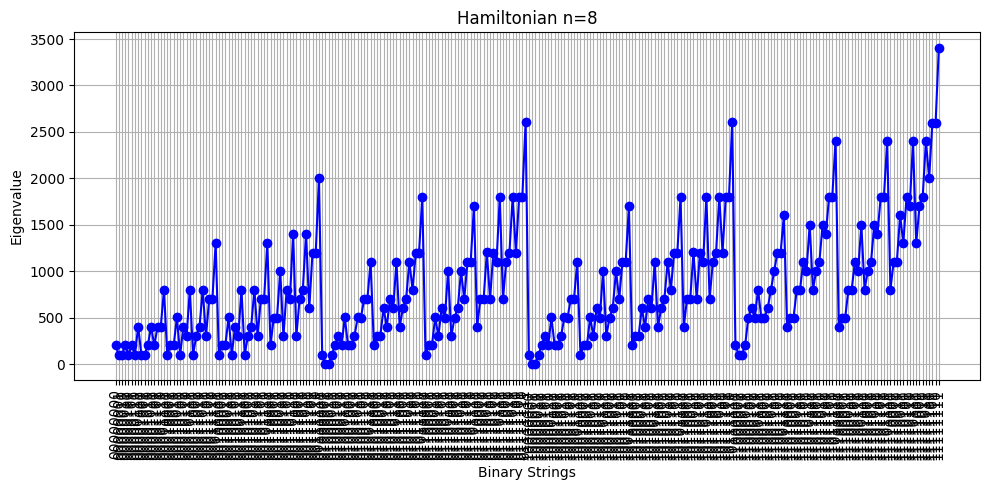

In [10]:
import numpy as np
import matplotlib.pyplot as plt

def foo(binary_string):
    # Example function: count the number of '1's in the binary string
    return get_expectation_value(initialize_state_from_string(binary_string), H_total_JSP)

def generate_binary_strings(n):
    total_strings = 2 ** n
    binary_strings = []
    
    for i in range(total_strings):
        binary_string = format(i, '0' + str(n) + 'b')
        binary_strings.append(binary_string)
    
    return binary_strings

def create_heatmap(n):
    binary_strings = generate_binary_strings(n)
    values = np.zeros((2**n, 1))  # Create an array to hold the function values

    for i, binary_string in enumerate(binary_strings):
        values[i] = foo(binary_string)

    # Reshape values for heatmap (1D to 2D)
    heatmap_data = values.reshape((2**n, 1))

    # Plotting the heatmap
    plt.figure(figsize=(10, 5))
    plt.imshow(heatmap_data, cmap='hot', interpolation='nearest', aspect='auto')
    plt.colorbar(label='Function Value')
    plt.title(f'Heatmap of the eigenvalues n={n}')
    plt.xticks([])  # Hide x ticks
    plt.yticks(range(2**n), binary_strings)  # Show binary strings on y-axis
    plt.xlabel('Binary Strings')
    plt.ylabel('Function Values')
    plt.show()

def create_2d_graph(n):
    binary_strings = generate_binary_strings(n)
    values = np.zeros(2 ** n)  # Create an array to hold the function values

    for i, binary_string in enumerate(binary_strings):
        values[i] = foo(binary_string)

    # Create x values (indices of binary strings)
    x_values = np.arange(len(binary_strings))

    # Plotting the 2D graph
    plt.figure(figsize=(10, 5))
    plt.plot(x_values, values, marker='o', linestyle='-', color='b')
    plt.xticks(x_values, binary_strings, rotation=90)  # Show binary strings on x-axis
    plt.xlabel('Binary Strings')
    plt.ylabel('Eigenvalue')
    plt.title(f'Hamiltonian n={n}')
    plt.grid()
    plt.tight_layout()  # Adjust layout to make room for x-axis labels
    ax = plt.gca()
    #ax.set_ylim([-1000, 0])
    plt.show()

# Example usage
create_2d_graph(task.num_qubits)


In [12]:
# from qiskit_algorithms import NumPyMinimumEigensolver
# def get_exact_ground(hamiltonian):
#     # Instantiate the NumPy classical solver

#     eigensolver = NumPyMinimumEigensolver()

#     # Compute the result using the eigensolver on the Hamiltonian
#     result = eigensolver.compute_minimum_eigenvalue(operator=hamiltonian)

#     # Extract the eigenvalue and eigenstate
#     eigenvalue = result.eigenvalue

#     return eigenvalue

# print(get_exact_ground(H_total_JSP))

**MUB Solver**

attempting all MUB states over the operator JSP Problem
Energy Landscape:


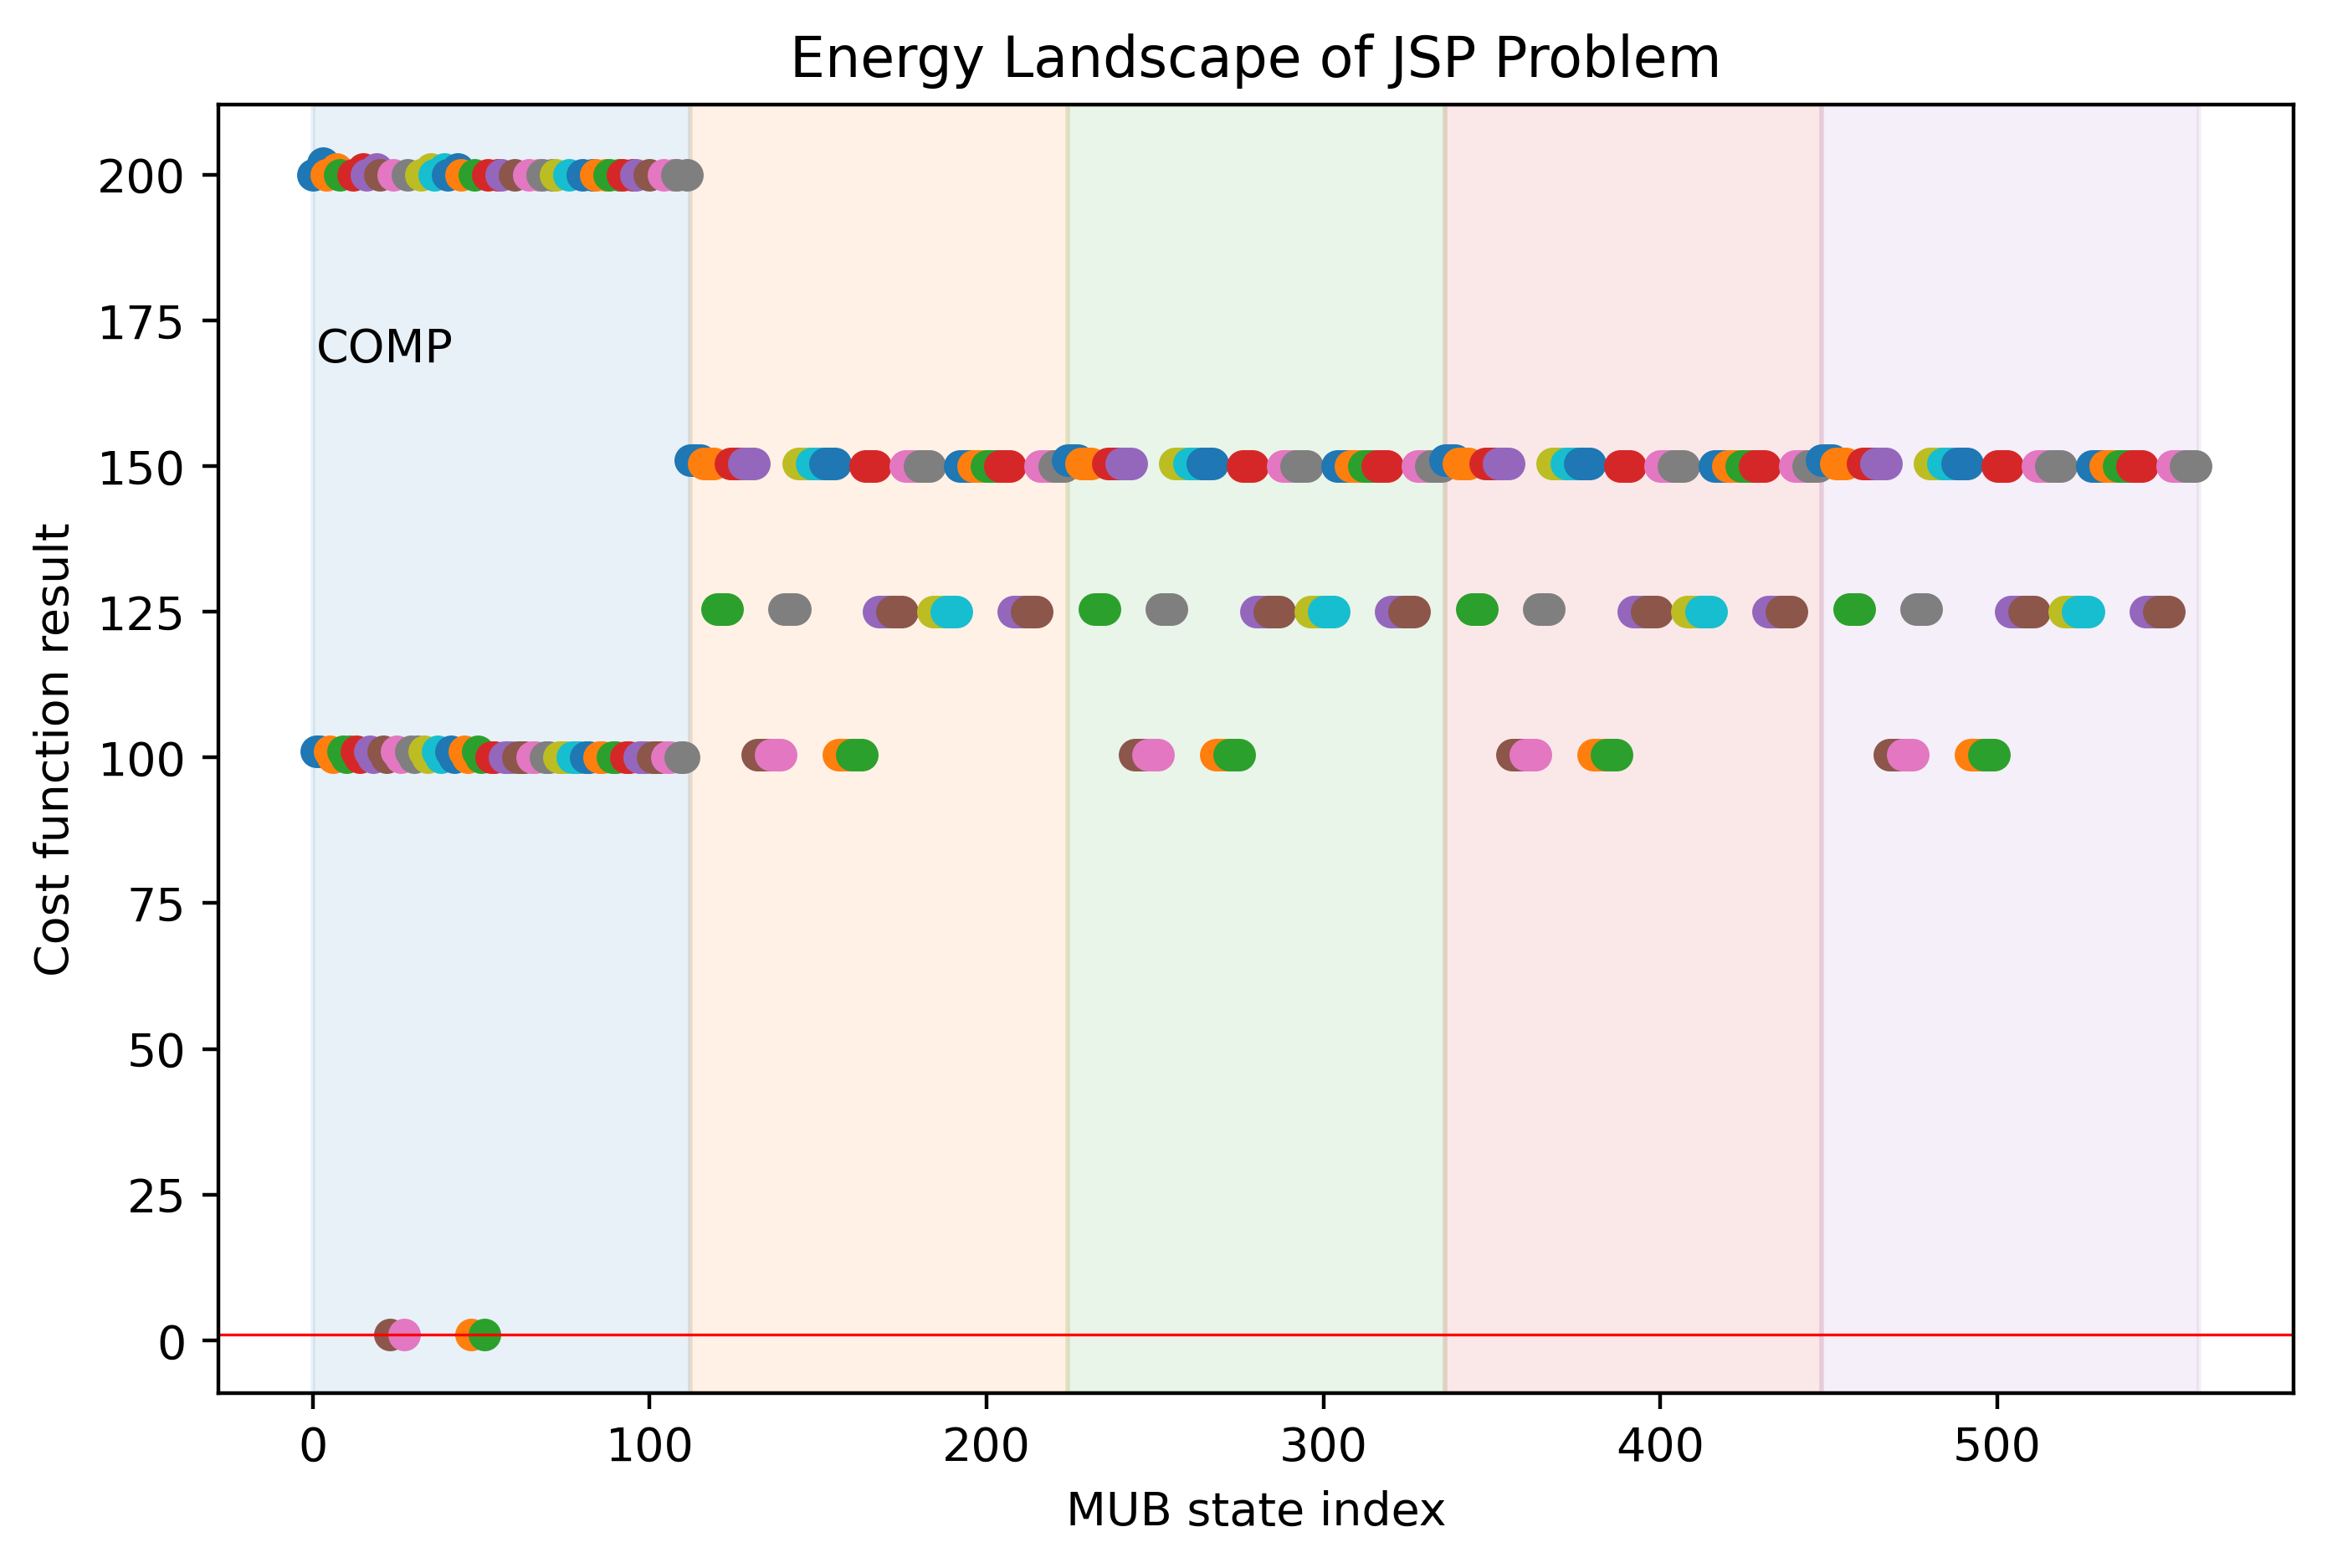

Energy Histogram:


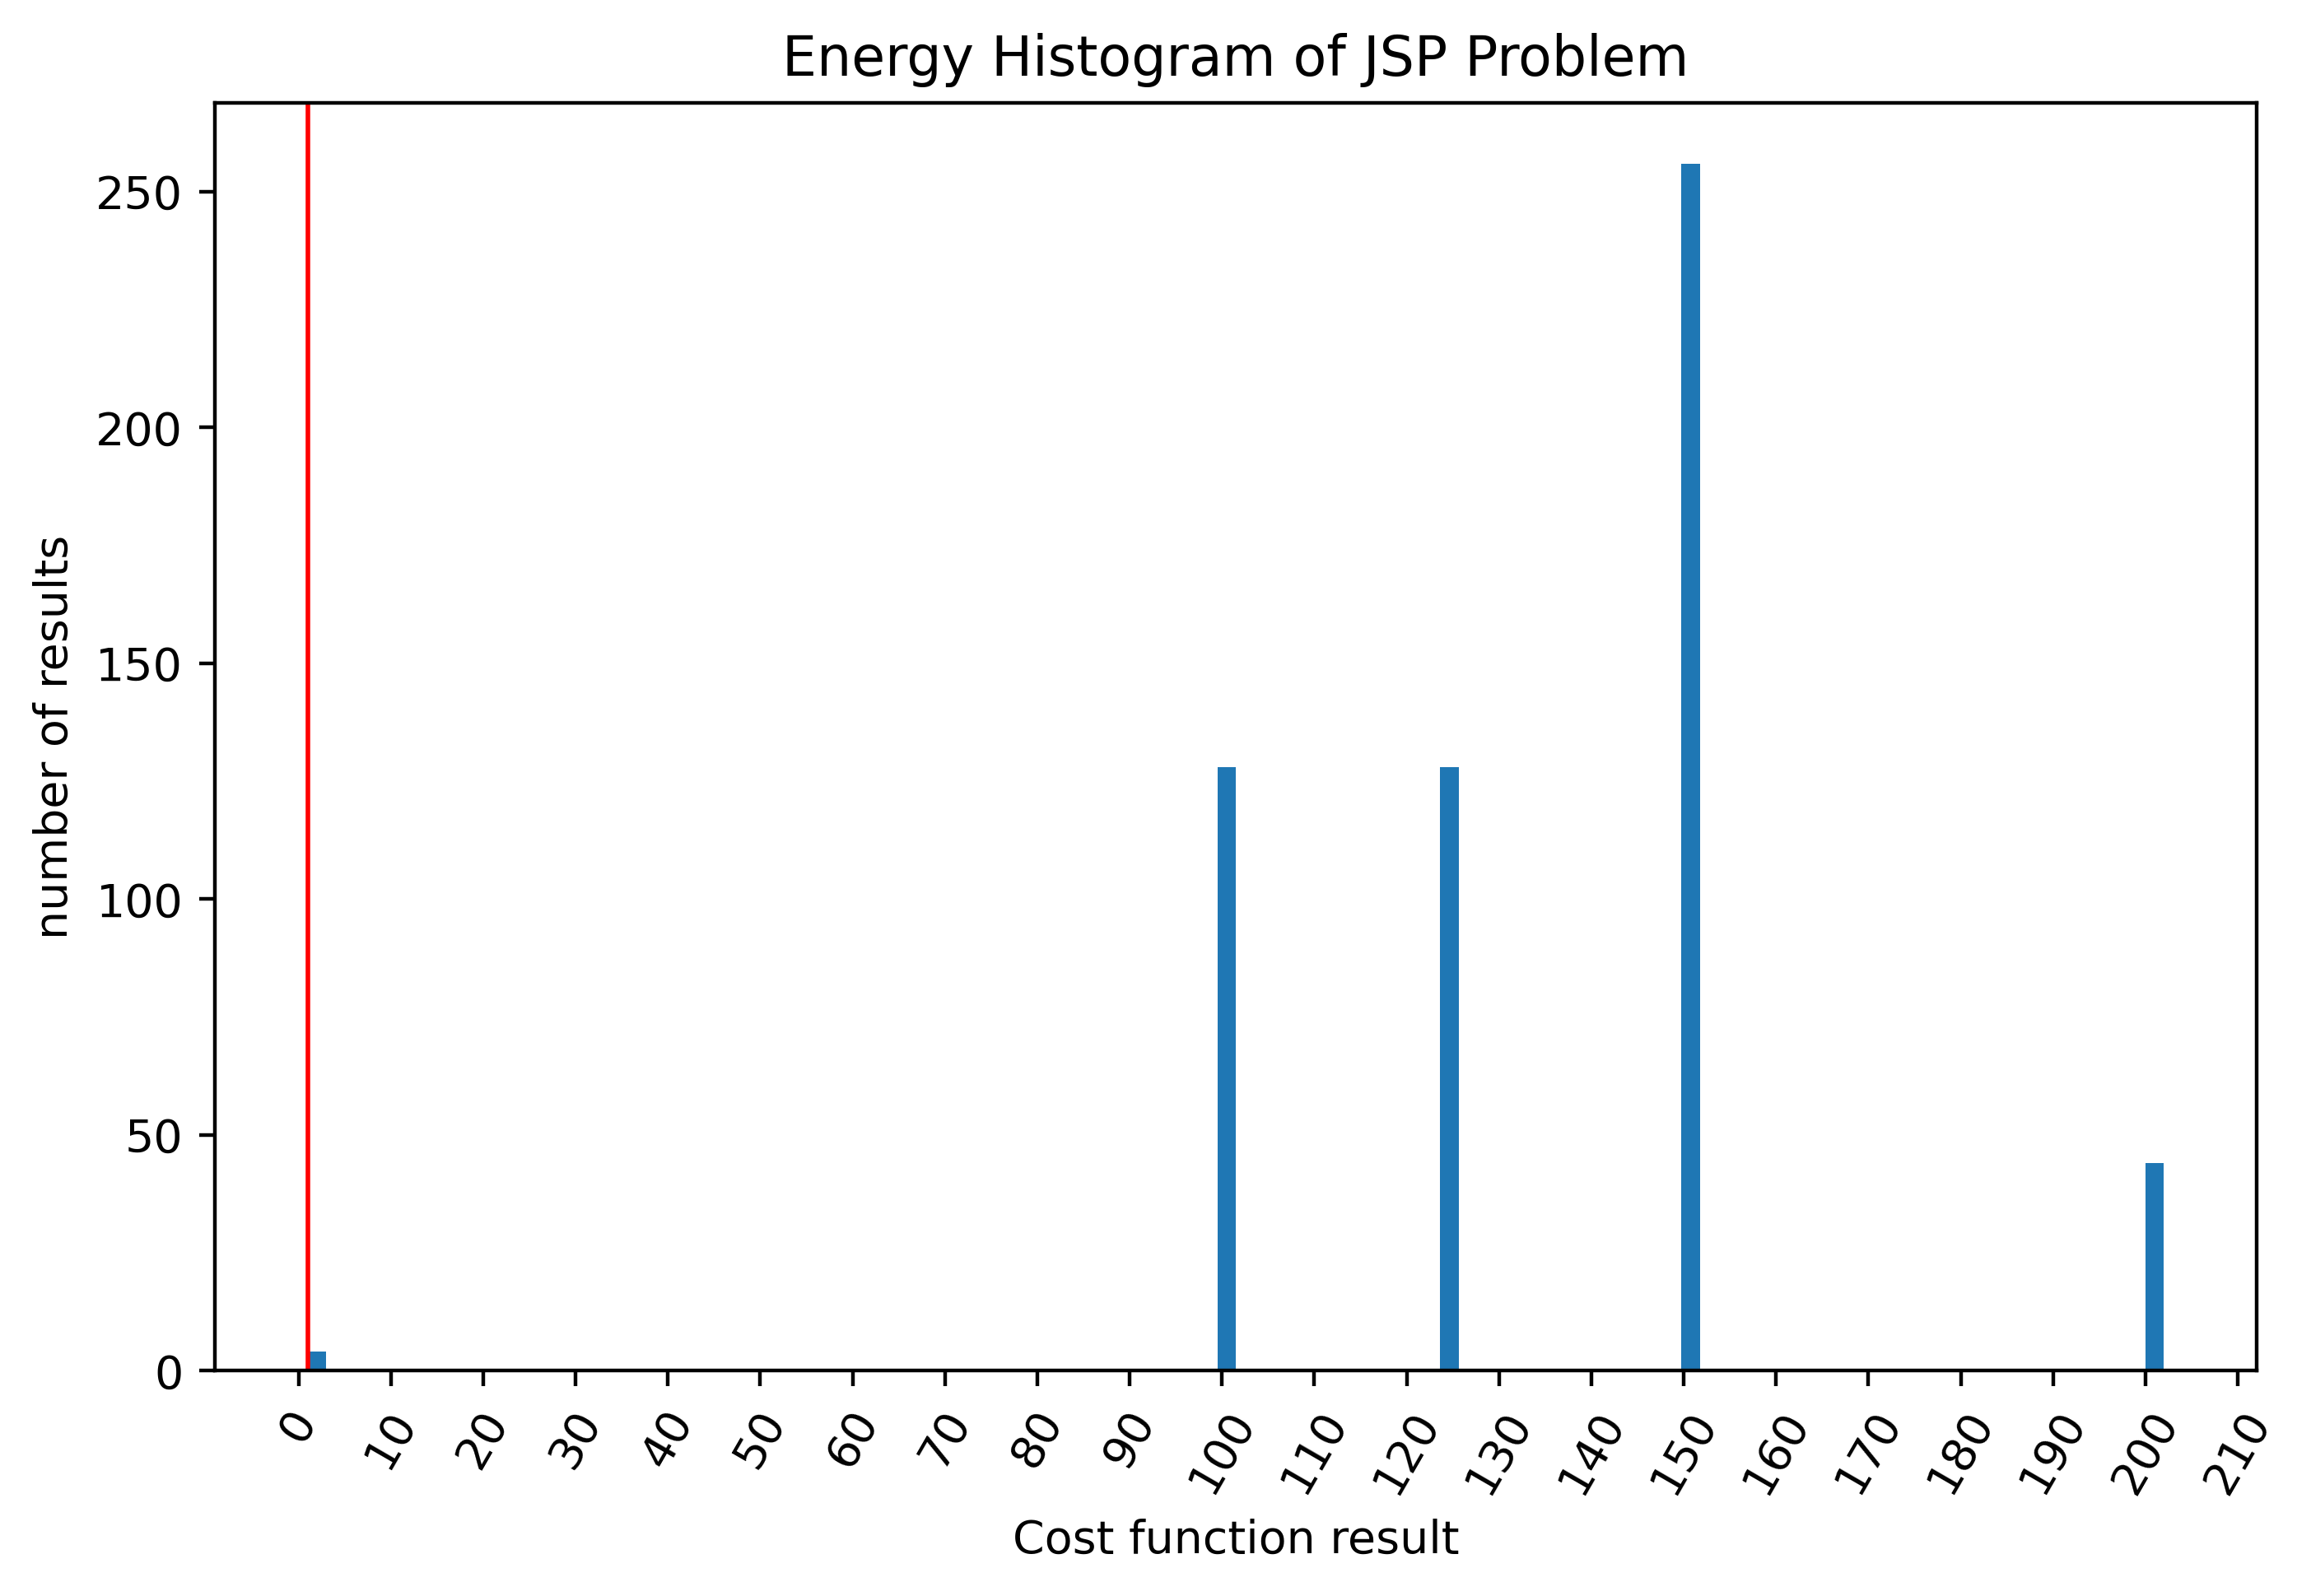

In [12]:
from experiment_utils import *

#####

landscape = run_and_record_landscape(H_total_JSP, 2, "JSP Problem")

**Ordinary VQE Experiment**

In [19]:
# '''
# Local minimum / Barren plateu parameters:
# [ 3.13187972  3.12485043 -1.44129882  4.00258695  1.8533889  -3.12973059
#  -1.08003222  1.32447117 -3.06463937 -1.37484716  3.00077516  2.21082978
#  -0.48120423 -0.65864836 -1.87660719  2.90869065 -0.01450286  0.0056704
#  -1.24626281 -1.18387608  0.84658704  0.143061    1.08438938  3.01307439
#  -2.92390669 -1.35869707  2.22695821 -1.74882826 -1.24884991  1.04685626
#   4.12047077 -0.1012765   3.14070326  0.01168365 -0.26387405 -2.08641117
#  -2.02884714 -0.67421794 -3.14378263 -0.04925929  1.80073301  3.12473985
#  -0.54310333  3.04640342 -1.34794034 -1.14862973 -0.00511756  0.30066454
#   0.011112    3.15367366  1.08694752 -1.66558516 -0.18201067 -0.91444362
#   1.57954499 -1.57272221 -0.98917923 -1.18253121 -3.31701255 -1.3658075
#   0.35165013  1.23242994 -0.80157646 -2.42548444]
# '''
# ### INITIAL THETA [1.0]*ansatz.num_parameters GETS STUCK, INITIAL THETA [0.0]*ansatz.num_parameters CONVERGES

NUMBER OF QUBITS 8 8
Ground state energy: 100.50028128823624
Optimal parameters: [ 3.14401532e+00 -3.58215039e-02  3.17659735e+00  2.79576675e+00
 -3.14458157e+00  3.30965090e+00  1.77959949e+00  3.02053504e+00
 -3.55261858e+00  7.54942755e-01 -8.66589949e-01  3.34484651e+00
  1.05275258e+00  2.60631088e+00 -8.80901664e-01 -1.92039074e+00
  7.97546959e-02 -3.04243927e+00  2.00057551e+00  2.50413924e+00
  1.78102192e+00  1.90311536e-02  4.79946236e+00  2.43685035e+00
  2.06298757e+00 -9.55360499e-01 -1.17026049e-01 -3.12918028e+00
 -1.11518685e-01  1.11795077e+00  6.20954591e-01  2.47640538e+00
  1.18663735e-03  2.17904359e-02 -1.57071234e+00 -1.52086491e+00
 -1.95507707e+00 -1.01711029e-01 -1.23377793e+00  1.20144677e+00
 -4.54114999e-01  1.87534747e+00  2.49121000e+00 -9.22988982e-01
  1.47677681e+00  1.49629902e+00 -1.56258299e+00 -1.12273679e+00
  3.06322888e+00 -1.29477580e-02 -1.73309886e+00 -3.47826838e+00
  2.41900542e+00 -2.29731647e-02  1.57668962e+00  1.39407221e+00
  1.47205

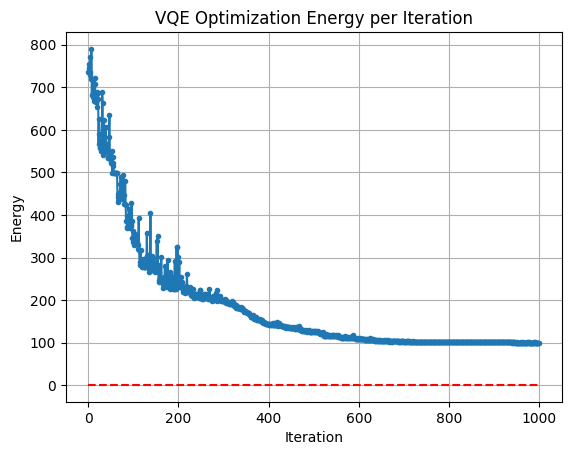

In [ ]:
from vqe import *

energy_values = []
theta_path = []
vqe_result = run_VQE_simple(H_total_JSP, energy_values, theta_path, min_eigenvalue.real, maxiter=1000, seed=42)
vqe_final_thetas = vqe_result.optimal_point

**Perturbed from Local Minimum**

In [18]:
# epsilons = np.linspace(0, 0.2, 3)
# average_distance_from_local_minimum = []
# std_distance_from_local_minimum = []
# average_final_score_function = []
# std_final_score_function = []
# #std as well

# for epsilon in epsilons:
#     distances = []
#     eigenvalues = []

#     for s in range(5): #average
#         #Just for sampling
#         np.random.seed(s)
#         perturbed_thetas = vqe_final_thetas + epsilon * np.random.uniform(-1, 1, len(vqe_final_thetas))

#         energy_values = []
#         theta_path = []
#         result = run_VQE_simple(H_total_JSP, energy_values, theta_path, min_eigenvalue.real, initial_thetas=perturbed_thetas, maxiter=2000, seed=s, verbose=False)
        
#         distances += [np.linalg.norm(result.optimal_point-vqe_final_thetas)]
#         eigenvalues += [result.eigenvalue.real]
    
#     average_distance_from_local_minimum += [np.average(distances)]
#     std_distance_from_local_minimum += [np.std(distances)]
#     average_final_score_function += [np.average(eigenvalues)]
#     std_final_score_function += [np.std(eigenvalues)]

In [17]:
# import matplotlib.pyplot as plt

# plt.figure(figsize=(12, 5))

# # Create the first plot: Average Distance from Local Minimum vs Epsilon
# plt.subplot(1, 2, 1)
# plt.plot(epsilons, average_distance_from_local_minimum, marker='o', linestyle='-', color='b', label='Average Distance')
# plt.fill_between(epsilons, 
#                  [avg - std for avg, std in zip(average_distance_from_local_minimum, std_distance_from_local_minimum)],
#                  [avg + std for avg, std in zip(average_distance_from_local_minimum, std_distance_from_local_minimum)],
#                  color='b', alpha=0.2, label='Std Deviation')
# plt.title('Average Distance of the Final Point from Local Minimum vs Epsilon')
# plt.xlabel('Epsilon')
# plt.ylabel('Average Distance')
# plt.grid()
# plt.legend()

# # Create the second plot: Final Score vs Epsilon
# plt.subplot(1, 2, 2)
# plt.plot(epsilons, average_final_score_function, marker='o', linestyle='-', color='r', label='Average Final Score')
# plt.fill_between(epsilons, 
#                  [avg - std for avg, std in zip(average_final_score_function, std_final_score_function)],
#                  [avg + std for avg, std in zip(average_final_score_function, std_final_score_function)],
#                  color='r', alpha=0.2, label='Std Deviation')
# plt.title('Final Eigenvalue vs Epsilon')
# plt.xlabel('Epsilon')
# plt.ylabel('Final Eigenvalue')
# plt.grid()
# plt.legend()

# # Show the plots
# plt.tight_layout()
# plt.show()


In [ ]:
# for i in range(4):
#     visualize_path_2d(theta_path, i, i+1)
# for i in range(4):
#     visualize_path_1d(theta_path, i)

**Running on MUB initial states**

NUMBER OF QUBITS 8 8
Ground state energy: 100.9109138461168
Optimal parameters: [-9.98330558e-03 -1.46866950e-02 -8.79191404e-01  1.09445733e+00
 -1.44281991e-02  7.92305076e-03  1.05522286e+00  4.66622153e-01
 -2.53783097e-03  4.87061955e-03  3.46865908e-02  1.32067041e-03
 -1.03401699e-01  1.10027152e+00  1.64966813e+00  8.83473941e-01
  7.71068175e-01  2.54507371e+00  1.56633566e+00  1.02312581e+00
  1.40481411e+00  1.21536662e-03  6.99588169e-01  1.45171165e-01
 -2.99719997e-03  1.51324640e+00  2.16575954e-01  1.72570922e+00
  1.08215945e-01  8.96090743e-01  1.58259583e+00  9.74947572e-01
  4.07251006e-02  7.17420594e-02  4.30363764e-01  3.32597136e-01
  8.08140416e-01  1.00182316e+00  1.36744266e+00  1.54027518e+00
  2.46049088e+00  7.06516442e-01  7.18862789e-03  9.81393386e-01
  1.31268245e+00 -1.20629956e-02  1.81337490e+00  2.92675918e-01
  6.11627730e-02  1.46486222e+00  2.68920502e-01  5.47833315e-01
  8.87796245e-01  9.38662382e-01  2.26445757e-01  8.50391198e-01]


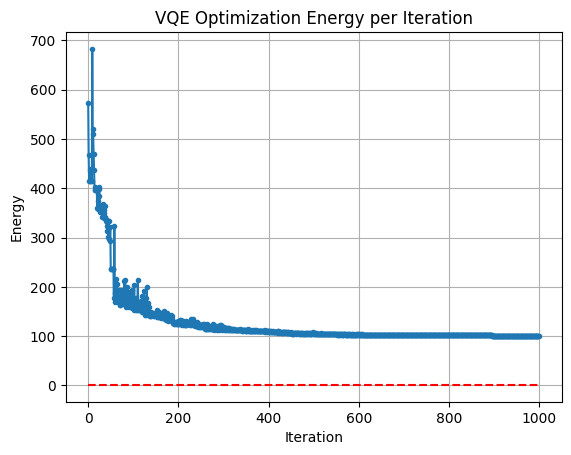

In [ ]:
from experiment_utils import *
from vqe import *

energy_values = []
theta_path = []

run_VQE_MUB(H_total_JSP, min_eigenvalue.real, energy_values, theta_path, state_idx=3, mub_idx=2)

**All MUB states for first 2 qubits**

In [13]:
from experiment_utils import *

run_VQE_MUB_for_all_mubs_on_first_2q(H_total_JSP, min_eigenvalue.real)

ITERATION 0 === MUB VQE STATE (mub_idx=0, state_idx=0)


capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.


KeyboardInterrupt: 

ITERATION 0 === MUB VQE STATE on (np.int64(0), np.int64(1))
ITERATION 0 === MUB VQE STATE (mub_idx=0, state_idx=0)
Ground state energy: 100.00905628516728
Optimal parameters: [-3.12542888e-04  1.75473391e-03  3.55928550e-01  9.55515251e-01
  4.37977484e-03 -1.69787475e-03  2.79083013e-02 -6.26453020e-01
  1.54386178e-03  1.87214562e-03  1.54770188e-03  1.86098154e-03
 -5.65947841e-02  5.44392561e-01 -3.73909991e-01  2.48960425e+00
  5.76921104e-01  9.11638150e-02  1.84641634e+00  8.08487499e-01
 -2.02162748e-04  1.65295786e+00  3.37765443e-04  1.92190526e-03
  5.91005160e-01  1.42399452e-01  1.26266878e+00  1.95907926e+00
  1.65731960e+00  1.23242939e+00  1.08275696e-01  2.47888377e+00
  8.52953193e-03  1.36951478e-02 -1.35280740e-02  4.70403109e-02
  3.83212120e-01  7.62356694e-01  1.40997809e+00  6.91307561e-01
  4.98205891e-01  9.03911297e-01  1.75419473e+00  1.19812757e+00
 -4.91850192e-03  1.37908066e+00  1.61003348e-03  1.68568490e+00
  4.99429032e-01 -3.09190462e-02  1.86881516e

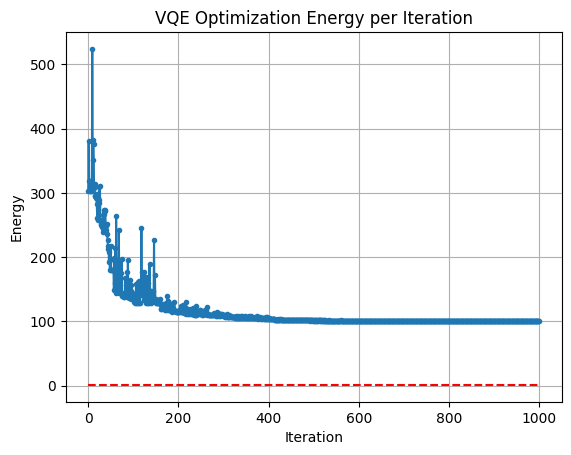

ITERATION 1 === MUB VQE STATE (mub_idx=0, state_idx=1)
Ground state energy: 100.0901515752213
Optimal parameters: [-9.35577409e-04  1.06444733e+00  5.84150041e-01 -2.91140505e-03
  6.28448755e+00 -1.06964479e+00  7.28307118e-01  2.22674989e+00
  1.59865901e-03 -2.79635036e-02 -8.67125091e-04 -1.01013272e-02
  1.94550658e-01  6.68702036e-01  2.11326540e-01  2.52550984e+00
  1.15063291e+00  1.65659212e+00 -3.69437412e-01  2.14379010e+00
  1.33197287e+00  3.88284062e-02  2.07706032e+00  1.67617332e-04
  1.40736149e+00  2.19562495e+00  1.35008397e-01 -8.63607365e-02
  1.54948113e+00  6.19741212e-01  1.58286404e+00  1.93624583e+00
  1.13233102e+00  1.21963245e+00  6.17519545e-02  2.65063778e-02
  1.92409555e+00 -1.72950254e-01  7.64926620e-01  2.01075634e+00
  6.18488197e-01  1.02779738e+00  1.27679459e+00  1.83034671e-01
 -4.54464450e-01  1.75764360e-01  8.26323603e-01 -4.56954062e-03
  1.56333155e+00  9.19998266e-01  4.91421026e-01  8.24153147e-01
  7.50905837e-01  6.97525171e-01  3.72435

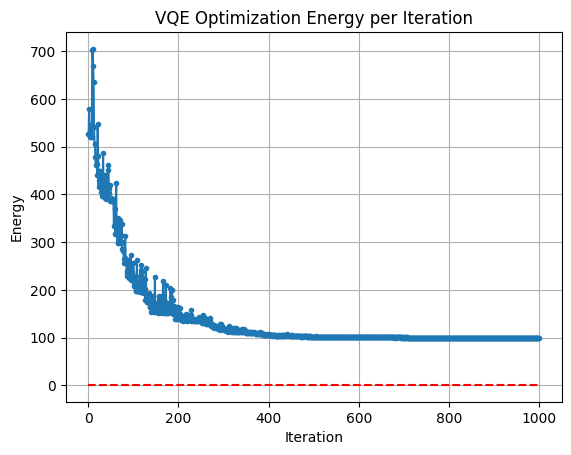

ITERATION 2 === MUB VQE STATE (mub_idx=1, state_idx=0)
Ground state energy: 100.04775823789392
Optimal parameters: [ 1.24652752e-03 -7.09398496e-03  2.04784028e-01  7.37120261e-01
 -1.07298746e-03  7.85975103e-03  2.15923791e-01 -4.55933454e-01
  1.70656064e-03  1.68564332e-03 -2.80269287e-02  6.44568751e-03
  5.30301764e-01  9.62037140e-01 -1.99975737e-01  1.76524948e+00
  1.16136670e+00  6.48535730e-01  5.29228232e-01  1.84790766e+00
 -1.65918880e-02  1.34700579e-03  1.93755504e+00 -3.74516737e-02
  8.51218712e-01  2.05978740e+00  1.13458111e-02  5.24447329e-01
  2.07308099e+00 -9.59473370e-01  2.21795219e+00  1.16522763e+00
 -9.77886058e-05 -2.18646424e-02  2.23433667e-01 -8.68098059e-02
  1.98544316e+00 -6.33887095e-01  1.88438572e+00  1.80237500e-01
 -4.13831092e-01  1.47350331e+00  8.83168107e-01  1.04691273e+00
 -1.86830085e-03  1.31117544e-02  1.18867578e+00 -5.31270518e-03
  1.44452710e+00  1.41074508e+00  6.28589807e-01  1.63755091e+00
  7.93480074e-01 -7.56292428e-01  4.7545

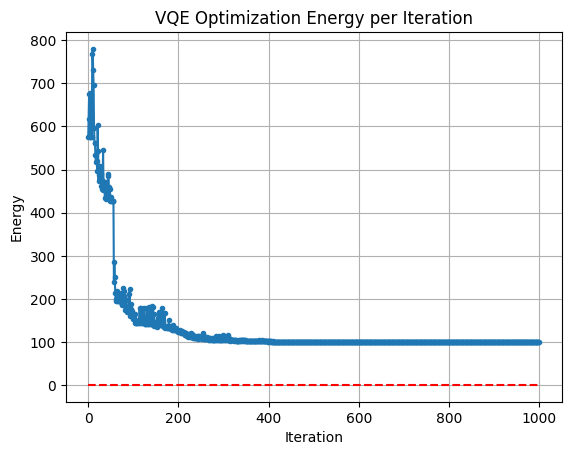

ITERATION 3 === MUB VQE STATE (mub_idx=1, state_idx=1)
Ground state energy: 100.02441990874993
Optimal parameters: [ 6.25647015e-01 -1.57078645e+00  5.19048107e-04  1.25981076e-03
  6.22714050e-01  1.56952645e+00  2.74676502e+00  4.73296433e-01
  1.03296937e-03  1.14856202e-03 -2.22093177e-03  7.49082651e-03
  7.94054062e-02  2.10763318e-01  1.60473092e+00  7.80722145e-01
 -3.09614256e-01  1.39493269e+00  1.69871529e+00  1.31168288e+00
  4.62649968e-03 -1.73979722e-03  1.61253370e+00  8.20644172e-03
  1.57180842e+00  4.74318596e-01  5.72237468e-01  1.55244037e+00
  1.40527427e+00 -6.66477967e-01  1.98246105e+00  1.03549148e+00
  1.14886162e-03  3.30787642e-01  4.54822822e-02  3.41436159e-02
  3.31466889e-01 -9.31114937e-02  1.87159631e+00  1.31407586e-01
  7.46206532e-01  9.95041441e-01  7.85559908e-01  4.63695026e-01
  4.20167054e-03 -3.33291532e-01  1.53451179e+00 -2.18673025e-03
  1.57249375e+00  6.37529613e-01  4.99094661e-01 -6.27943296e-01
 -1.41488165e+00  2.17508321e+00 -2.8134

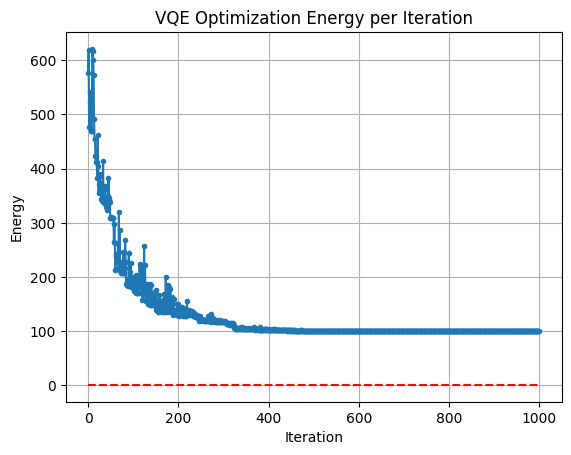

===== SUCCESS RATE FOR GLOBAL MINIMUM 0/4=0.0%
ITERATION 4 === MUB VQE STATE on (np.int64(0), np.int64(2))
ITERATION 0 === MUB VQE STATE (mub_idx=0, state_idx=0)
Ground state energy: 100.01791856765344
Optimal parameters: [ 5.21235544e-04  1.96371278e-02  7.75657632e-01 -5.62011985e-01
  4.80884044e-04 -1.89996320e-02 -1.08939422e+00 -3.18093128e-01
 -4.04745754e-04  1.14957625e+00 -5.00516133e-03  8.64809947e-04
  7.51645153e-02  1.31995345e+00  1.63830352e+00  1.29836703e+00
  1.16486255e+00  1.04991495e+00  1.92220707e+00  1.04114726e+00
  2.45122027e-03  1.13971490e-01  1.26700043e+00 -3.30716221e-03
  1.50503201e+00  6.05807994e-01  7.02702741e-01  2.21448000e-01
  1.67435253e+00  7.04823628e-01  1.61794653e+00  6.93930394e-01
 -4.62683189e-04  1.47085709e+00  1.59444751e+00  1.17403145e+00
  1.64250852e+00 -7.84302577e-02  1.17091163e+00  1.22710125e+00
  7.16511454e-01  1.59892601e+00  9.80165556e-01  6.46136518e-01
  8.02709853e-04  1.33793600e-01  5.84477470e-01 -2.29355888e-0

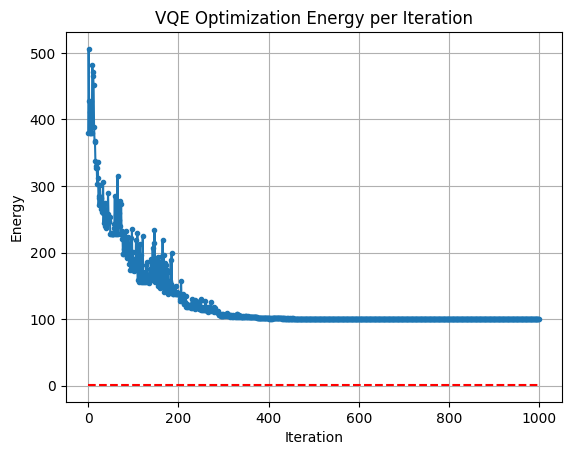

ITERATION 1 === MUB VQE STATE (mub_idx=0, state_idx=1)
Ground state energy: 100.10863145530442
Optimal parameters: [ 1.88117588e-04  4.41587383e-01  6.88434990e-01  8.07279131e-02
  6.29530727e+00 -4.31170622e-01  3.24580197e-01 -4.98266447e-01
  8.69465717e-03  6.56751196e-01  2.68002522e-03 -1.37543767e-02
  1.41094180e-01  1.81239923e+00  2.14852686e+00  1.78360969e-01
  9.66152928e-01  8.00612178e-01  1.36797532e-03  2.16159346e+00
  6.20160990e-04 -9.19173589e-01  1.59091549e+00 -5.53032294e-02
  1.91019717e-01  4.40784631e-01  1.31961814e-01  8.30594881e-01
  4.65158113e-01  5.12961717e-01  7.46099363e-01  1.32127642e+00
 -3.44974370e-03  1.88933068e+00  1.03173089e+00  1.50309816e+00
  1.66635391e+00 -2.36042180e-02  1.85785008e+00  1.35874735e+00
  1.37868188e+00  2.53417155e-01  1.06276663e-01 -3.96353937e-01
 -1.15962697e-03  8.92485354e-01  2.78944677e-01  2.57201058e-01
  1.61942621e+00  1.48243902e+00  2.14786796e-01  1.28760154e+00
  4.74699262e-01  2.31515931e+00  1.2110

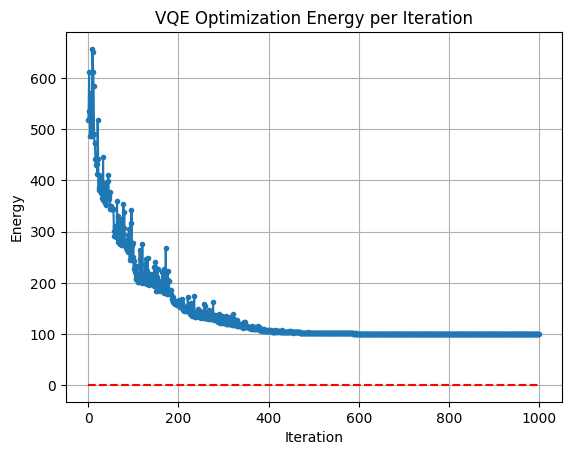

ITERATION 2 === MUB VQE STATE (mub_idx=1, state_idx=0)
Ground state energy: 100.01929299469079
Optimal parameters: [ 7.04480023e-01 -1.57007314e+00 -2.04506252e-03 -1.31615523e-03
  7.04211847e-01  4.89045562e-01  9.56873985e-01 -3.60378937e-01
 -1.94754185e-03 -7.72139560e-03  4.78825886e-03  6.80778729e-01
 -3.03938324e-01  1.51829287e+00  1.01400662e+00  1.46977451e+00
  2.61484599e+00  9.74006718e-01  1.58080383e+00  1.98375922e+00
 -1.98650408e-05 -2.92479191e-04  1.71939263e+00  1.47917174e-02
  1.68267979e+00 -8.50357242e-02  1.32358052e+00  1.75857284e-01
  1.49971822e+00 -4.10319797e-01  1.46570415e+00  1.13907080e+00
 -2.01120098e-03 -2.22393297e-02 -1.29983703e-01  6.62661927e-02
  1.68544854e+00  2.73640564e-01  1.59426217e+00  3.22967790e-01
  1.10216970e-01  1.53908669e+00  1.66910562e+00  2.23041766e-02
  3.22716258e-04  2.08364521e-02  1.39788088e+00 -7.97096266e-02
  1.56727179e+00  1.56864358e+00  6.14555533e-01  8.61396196e-01
 -2.44873696e-01  1.55679538e+00 -2.4861

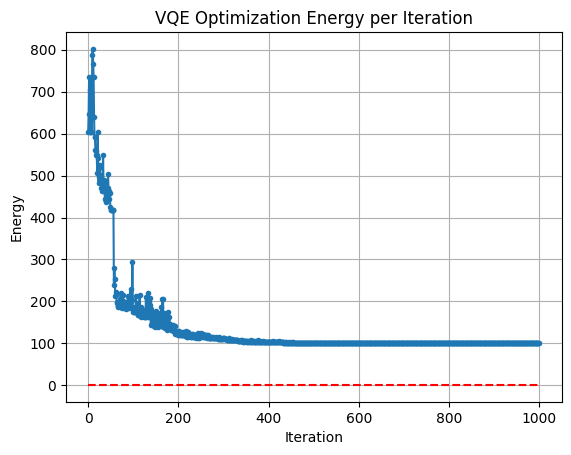

ITERATION 3 === MUB VQE STATE (mub_idx=1, state_idx=1)
Ground state energy: 100.18211699126279
Optimal parameters: [ 2.11245305e-03 -2.90495855e+00 -7.20615509e-01 -1.81890326e-01
 -3.03364880e-03  2.88318535e+00  6.52836073e-01  7.27169895e-01
  1.30973001e-03 -7.53781695e-02 -1.35111784e-03  3.72258386e-03
  3.18409184e-01  1.35064451e+00  4.09269508e-01  1.28960327e+00
  1.65405834e+00  5.72326416e-01  8.68783234e-01  1.03966050e+00
 -2.11770324e-03  2.13250828e-01  1.32549321e+00 -2.68046020e-03
  9.37667707e-01  8.24644379e-01  2.47698246e-01  3.30598820e-01
  1.29514483e+00  1.69636649e+00  1.53430840e+00  1.05956973e+00
 -5.92900601e-04  1.74853763e+00  4.31890589e-01  5.07761449e-02
  1.95302012e+00 -2.40712315e-01  1.75594038e+00  1.89229164e+00
 -3.20766105e-01  1.01264474e+00  6.87534812e-01  7.92113179e-01
 -4.10906229e-03  1.65083147e+00  6.76015853e-01 -9.46824860e-03
  1.57196238e+00  7.36189319e-01  9.89876289e-01  5.39719845e-01
  1.38620399e+00  1.34213608e+00  5.6221

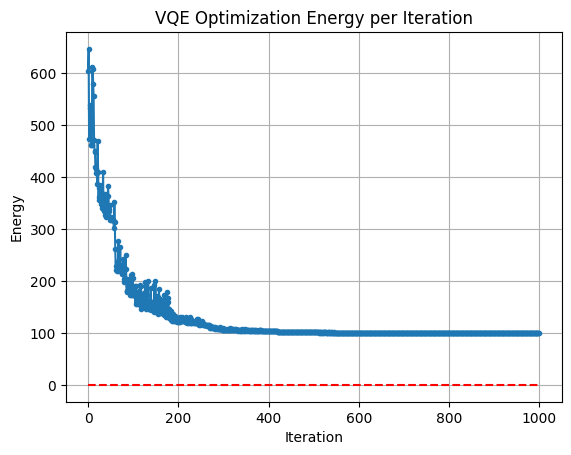

===== SUCCESS RATE FOR GLOBAL MINIMUM 0/4=0.0%
ITERATION 8 === MUB VQE STATE on (np.int64(0), np.int64(3))
ITERATION 0 === MUB VQE STATE (mub_idx=0, state_idx=0)
Ground state energy: 1.1458959794257126
Optimal parameters: [ 6.19032213e-03 -7.39238972e-02  2.36033617e-01 -4.14070906e-01
 -2.93692446e-03  6.34104367e-02 -9.54427427e-01 -8.60092865e-01
 -1.66884531e-03 -2.41186726e-03  8.78786087e-03  3.59030502e-02
 -9.34478715e-02  1.97495956e+00  3.30243473e-01  1.66860009e+00
  1.49326411e+00  6.96526470e-01  2.17807304e+00  1.80935078e+00
  1.55598995e+00 -3.59446811e-03  1.64106330e+00  5.08334363e-02
  1.42511305e+00  7.40159129e-01  3.34886451e-03  1.23944792e+00
  3.13129665e+00  4.68500326e-01 -4.45438725e-01  1.15052818e+00
  1.16730024e+00  1.16656039e+00 -9.03454967e-01  9.10857723e-01
 -1.74937926e-01  1.70466441e-02  1.25515171e+00  1.88980958e+00
 -1.51441624e-01  1.69774923e-01  4.28097993e-01 -7.89162472e-02
  1.58380190e+00 -7.67319743e-03  1.56324456e+00  8.35531483e-0

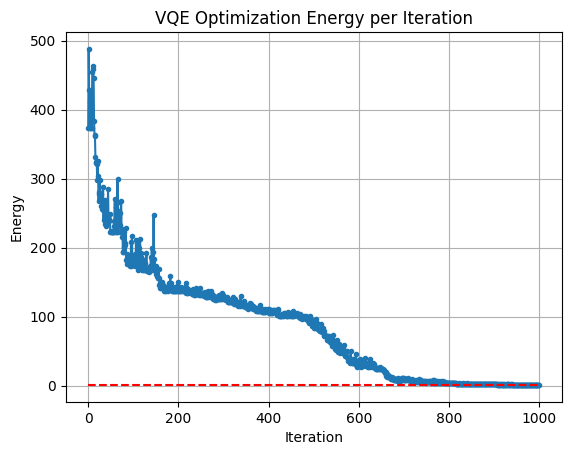

FOUND GLOBAL MINIMUM
ITERATION 1 === MUB VQE STATE (mub_idx=0, state_idx=1)
Ground state energy: 1.0742727994794083
Optimal parameters: [ 1.97651784e-03  5.14996973e-02  1.96558294e+00  5.89243270e-01
  3.15681945e+00 -5.38094871e-02 -1.25960207e+00 -7.72983341e-01
 -2.16780448e-03 -2.33434760e-03  5.72116935e-04  7.66591579e-03
 -2.14895558e+00  1.97140517e+00  1.08083953e+00  6.02775292e-01
  4.21697354e-01  1.48468807e+00 -5.40692758e-01  2.39297264e+00
  2.41756314e-03 -3.84952901e-04 -3.64528865e-03  5.86662052e-03
  3.56632469e-01  6.03079482e-01  5.99598089e-01  1.26763538e-01
  4.84348447e-01  1.81434612e+00  2.08846506e+00  1.72911417e+00
 -2.07252535e-03  4.06431509e-04 -1.31130290e-03 -7.77982039e-03
  2.08996186e+00  1.69627137e-01  2.01034354e+00  8.72018287e-01
  4.63189954e-01  3.18443489e-01  1.28192109e+00  6.79379471e-01
 -4.86342843e-03  8.48761090e-03 -4.40873245e-03 -4.83203131e-03
  8.88313702e-01  1.16103040e-01 -1.78623330e+00  1.71542361e+00
 -6.57945478e-01  1

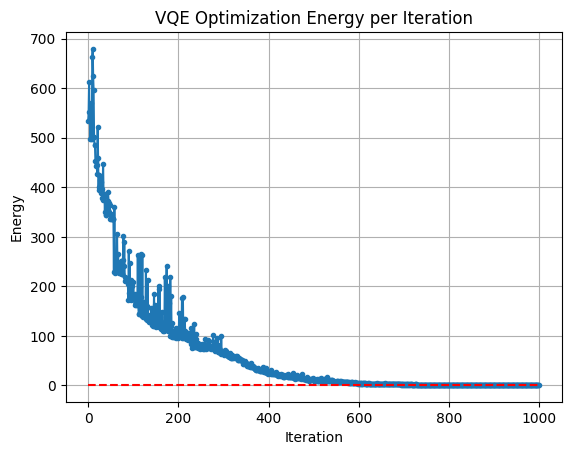

FOUND GLOBAL MINIMUM
ITERATION 2 === MUB VQE STATE (mub_idx=1, state_idx=0)
Ground state energy: 100.24699972016131
Optimal parameters: [ 3.60369048e-04 -5.61672986e-01 -1.25467041e+00  8.94203399e-04
 -2.15072941e-03  5.62695781e-01  4.70373102e-01  2.32705658e-01
 -2.33492837e-03 -1.53569675e-01  1.32449132e-01  8.68924845e-01
  7.44901577e-02  1.50783611e+00  2.15204330e+00  7.90034832e-01
  1.74248635e+00  2.48157894e-01  8.94085164e-01  1.71600845e+00
  3.61149257e-04  2.14464672e-01  1.82522736e+00  5.28000775e-02
  1.00244710e+00 -4.62645814e-01  1.37180483e+00  1.29513106e+00
  2.32998322e+00  1.04990156e+00  1.50662724e+00  1.41579014e+00
  3.04779281e-03  6.79833337e-01 -3.52237684e-01  6.31054826e-01
  2.05100880e+00 -3.40928112e-02  1.69337072e+00  1.07242821e+00
  9.86997944e-02  5.66803609e-01  1.02993374e+00 -5.66677033e-02
 -8.06502833e-04  1.10417095e+00  7.58455544e-01  3.22112402e-01
  1.34958093e+00  1.53656946e+00  1.05363770e+00  1.70590090e+00
  1.52260465e+00  9

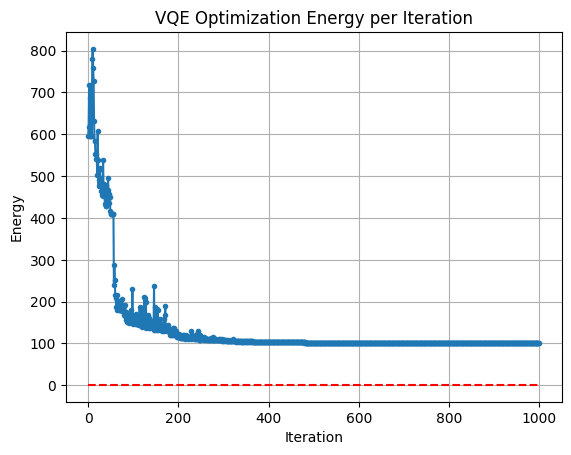

ITERATION 3 === MUB VQE STATE (mub_idx=1, state_idx=1)
Ground state energy: 1.2424638254010771
Optimal parameters: [-3.05041082e-03 -2.59749697e+00 -7.10075184e-01  4.53148919e-03
  3.32296182e-05  2.60674146e+00  1.45292133e-01 -2.80346718e-01
 -7.74850681e-04 -5.59439242e-04 -1.78406904e-03  3.06206434e-03
  5.17023986e-01  1.55662300e+00  2.27986935e+00  1.50883106e+00
  6.51137760e-01  2.03638359e+00 -8.95242486e-02  1.95068437e+00
  1.85467732e+00 -5.61099158e-03  1.57340055e+00 -2.34520876e-03
 -1.13304030e+00  3.15103479e-01  2.21645465e-03  1.06199591e-01
  1.35192878e+00 -4.44343797e-01  1.45340813e+00  1.38978468e+00
 -2.41655113e-01 -2.44390402e-01  5.56347684e-05 -6.55361751e-04
  1.13820048e+00  7.28806670e-02  1.86378399e+00  1.27596154e+00
  3.68635828e-01  1.41983488e+00  1.80501972e+00  4.18084027e-01
  1.27752206e+00  9.74031656e-03  1.56994718e+00 -1.08813393e-04
  1.57146544e+00  1.20691698e+00  8.66306658e-01  2.76795206e-01
 -1.43832953e-01  2.84826073e-01  7.2826

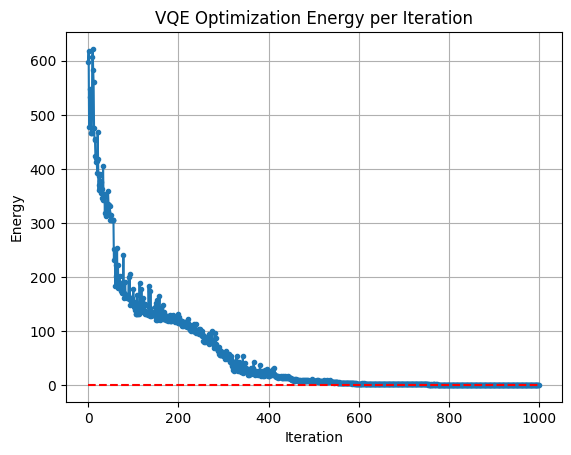

FOUND GLOBAL MINIMUM
===== SUCCESS RATE FOR GLOBAL MINIMUM 3/4=75.0%
ITERATION 12 === MUB VQE STATE on (np.int64(0), np.int64(4))
ITERATION 0 === MUB VQE STATE (mub_idx=0, state_idx=0)
Ground state energy: 11.115169956468119
Optimal parameters: [ 0.02679612  0.26203548  1.19044151  3.05653955 -0.0038795   0.26183922
  0.85978903  1.0099548   0.02188982  2.89234177 -0.07933617  0.32035903
 -0.53797287  1.29259043  0.41279699  1.37364956  0.62818162  0.41078999
  0.68627517  2.61865547  1.53635032 -0.53161006  1.53479322  1.8789484
  0.03460527 -0.20016443  0.02974106 -0.17325052  2.95617059 -0.11998387
  1.25648786 -0.13576414  1.54408485  1.54662867  1.43353325  1.43829054
  1.39633662 -0.23730739 -0.58890388  0.72362001  1.49106258  0.79438152
  1.34483013  0.7148932   1.34713919 -0.01467423  1.02457776  0.07851442
  2.56320553  1.52819901  0.41066239  0.2518775  -0.833891    0.74928153
  0.35655669 -0.34399087]


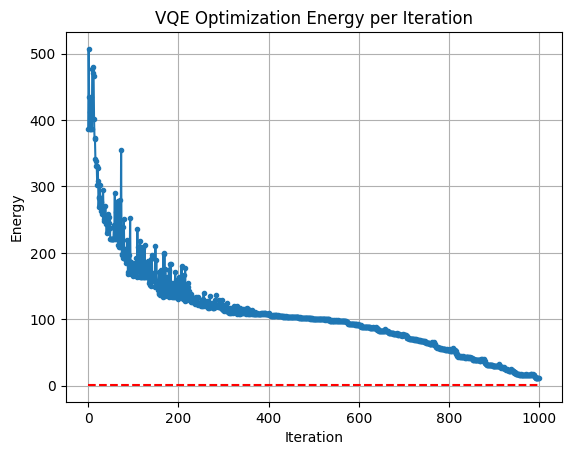

ITERATION 1 === MUB VQE STATE (mub_idx=0, state_idx=1)
Ground state energy: 2.018769472603642
Optimal parameters: [-1.05093290e-03  3.00065223e-01 -6.76042376e-01  3.00162190e-02
  3.17630821e+00 -3.06899790e-01  9.37090478e-01 -2.70161673e-01
 -9.69645624e-04 -3.79797603e-03  3.92584870e-02 -9.32274800e-01
  6.11229326e-01  1.65075418e+00  1.20553987e+00  1.95221221e+00
  1.78132458e+00  4.36653149e-01 -4.78387844e-01  2.52259288e+00
 -2.92259812e-02 -2.41701901e-02  1.09685239e+00 -6.76015261e-01
 -9.75610298e-01  4.64334481e-03  2.30368212e-02 -6.89562778e-01
  2.15075685e+00 -3.57142350e-01  1.29823247e+00  6.53969935e-01
  5.04750262e-03 -1.00968270e-01  9.26265496e-01 -4.57179456e-01
  2.64851650e+00 -1.20834483e-01  6.39592757e-01  3.77880825e-01
  2.99658339e-01  8.44492957e-01  1.18070438e+00  3.20713823e-01
 -4.51465158e-02 -1.04702832e-01  1.32944748e+00  4.42069840e-01
  1.47394428e+00  1.45354533e+00  8.71489809e-01  7.41827150e-01
  4.93568329e-01  1.72031840e+00 -6.55495

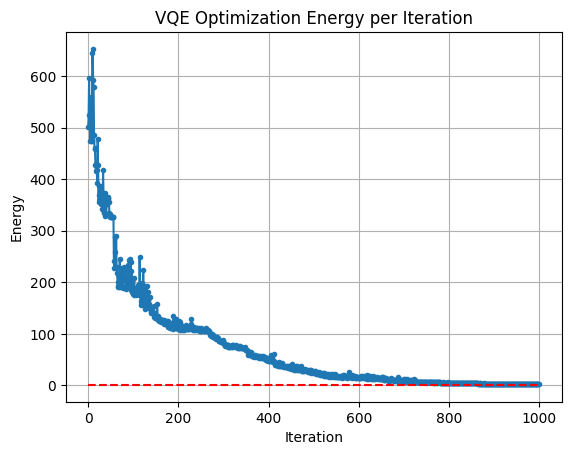

FOUND GLOBAL MINIMUM
ITERATION 2 === MUB VQE STATE (mub_idx=1, state_idx=0)
Ground state energy: 100.03509439319177
Optimal parameters: [ 2.90513005e-05 -5.64190874e-01  5.34090899e-01  2.29864898e-03
 -9.48477816e-04  5.58365839e-01  6.59530847e-01  7.50945075e-01
  3.10022637e-03  7.06455733e-03 -1.41712835e-01  2.18055442e-01
 -2.79989419e-02  1.88385427e+00 -5.77864946e-02  2.10660440e+00
  1.28837675e+00  1.56997983e+00  5.03432092e-01  2.49450760e+00
  2.83344139e-03  8.88237499e-03  1.49076817e+00  1.94053760e-01
 -3.58805528e-01  4.33258148e-01 -2.22237530e-01  5.93040512e-01
  2.07116596e+00 -3.41355907e-01  1.53912175e+00  5.75471041e-01
 -9.19750658e-04  7.85150190e-03  1.73548155e+00  1.06061900e+00
  1.06231620e+00 -5.13369881e-02 -2.74570561e-01 -1.07092093e-01
 -3.71716198e-01  3.01047140e+00  4.87848968e-01  2.89303091e-02
 -4.54344691e-03 -7.81429229e-03  1.31708350e+00  7.17552890e-01
  1.33859948e+00  1.58956045e+00 -2.16369843e-01  5.18543502e-01
  1.75762437e-01  1

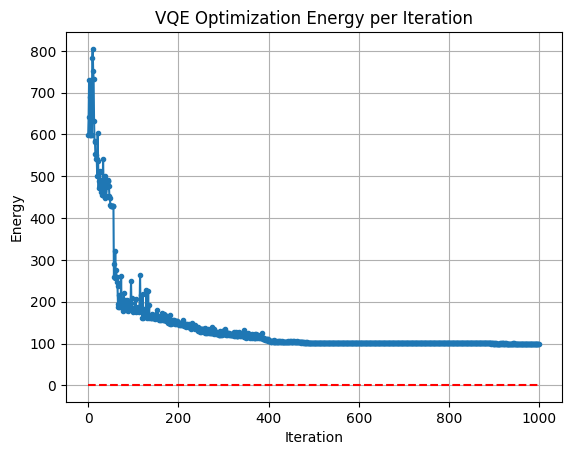

ITERATION 3 === MUB VQE STATE (mub_idx=1, state_idx=1)
Ground state energy: 100.02650182713113
Optimal parameters: [ 1.97763683e-03 -2.66008493e+00  2.15459710e+00 -1.23171369e-02
  1.00349149e-02  2.65649157e+00  1.63152485e-01 -7.36338454e-02
  4.97241082e-03  5.39426297e-03  6.22832877e-01 -4.18095684e-03
  2.34496192e-02  1.50553900e+00  6.86060152e-01  2.28272335e+00
  1.64981559e+00  1.30142495e-01  5.99290165e-02  2.58011485e+00
  8.27159848e-03  6.46976890e-03  1.38042799e+00 -6.48765139e-01
  8.02863578e-02  5.79268675e-02  9.00964363e-01  5.81656099e-01
  1.87913715e+00 -1.76985304e-01  1.24294841e+00  5.93432294e-02
  5.05662421e-04  1.44499642e-02  1.75082915e+00 -5.90578175e-01
  1.86664995e+00 -1.38971492e-01  4.81670324e-01  7.90279008e-01
 -4.98924251e-01  5.85207789e-01  8.86505726e-01  4.96776425e-01
  1.76656749e-03  8.77054733e-03  1.24194175e+00 -2.09933613e-01
  1.07880557e+00  1.54013722e+00  1.16989248e+00  2.08534120e+00
 -1.52699199e-01  1.01355028e+00  8.3531

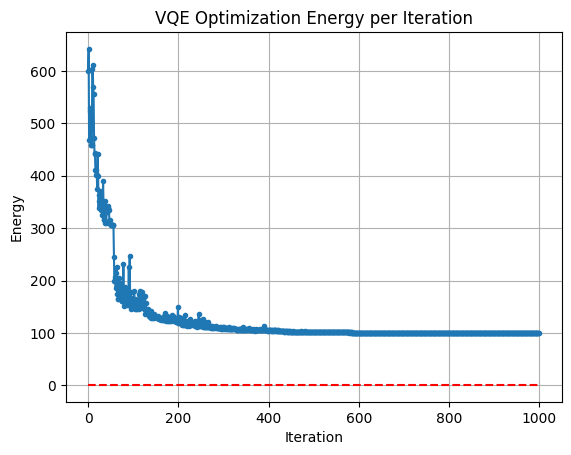

===== SUCCESS RATE FOR GLOBAL MINIMUM 1/4=25.0%
ITERATION 16 === MUB VQE STATE on (np.int64(0), np.int64(5))
ITERATION 0 === MUB VQE STATE (mub_idx=0, state_idx=0)
Ground state energy: 100.21294218623684
Optimal parameters: [ 2.04259085e-03 -3.12655353e-03  2.06496600e+00  9.56339696e-01
  3.60221820e-03  9.00529141e-03  4.12478411e-01 -4.94943289e-01
  5.10499840e-03  1.60905837e+00  4.37707194e-03 -1.52323277e-01
 -3.89412481e-01  1.35192973e+00  2.00893452e+00  2.19703861e+00
  9.77644799e-01 -1.73736314e-01 -2.81469991e-01  2.83269877e+00
  2.39163573e-03 -8.52900468e-01  1.95560643e+00  5.44531763e-02
  2.53937795e-01 -1.23488045e-01  3.66120494e-02  9.17034892e-01
  2.05118534e+00 -3.83276744e-01  1.43831303e+00  1.67883401e-01
  2.86477970e-03  2.15420478e+00  1.87016603e+00  3.94267167e-01
  1.77620017e+00 -1.24988868e-01  6.56724256e-01 -7.23708099e-01
 -7.98695970e-03  3.38228400e-01  5.86838966e-01  1.38385821e-01
  3.00095846e-03  8.21505878e-02  1.55323529e+00  1.01873801e

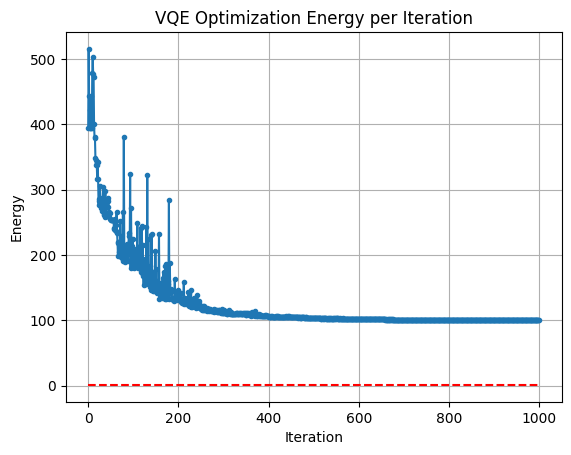

ITERATION 1 === MUB VQE STATE (mub_idx=0, state_idx=1)
Ground state energy: 2.7996653818131043
Optimal parameters: [-9.60383314e-01  1.49993408e+00  1.78587062e-02 -9.53878927e-03
  4.13921538e+00 -1.55217499e+00  9.38476950e-01 -2.47053638e-01
 -1.04593826e-02 -2.53814078e-03  2.53320971e+00 -1.33157211e+00
  6.45413631e-02  1.49947417e+00  1.20964346e+00  1.09574006e+00
  1.00238491e+00  8.38243103e-01  3.63654919e-01  2.07009057e+00
 -1.70558696e-03  8.77236161e-03  2.06563507e+00  1.15178012e+00
 -1.05179419e-02 -1.31877951e-01  3.31336695e-01 -8.04176066e-02
  2.33724995e+00 -2.76891052e-01  7.96942196e-01  1.04856554e+00
 -1.52768194e-03  2.90190266e-02  1.84037233e+00  7.02693347e-01
  1.75040472e+00 -4.74603536e-03  3.00355155e-01 -7.87358081e-01
 -2.73358675e-01  1.69628074e+00  1.89590437e+00 -1.94635076e-03
  9.73553149e-03  1.90813313e-02  1.16123487e+00  6.35689606e-01
 -1.26260741e+00  1.49220059e+00  1.62126596e+00  1.90498673e+00
  1.66466591e-01  1.32159165e+00  1.0674

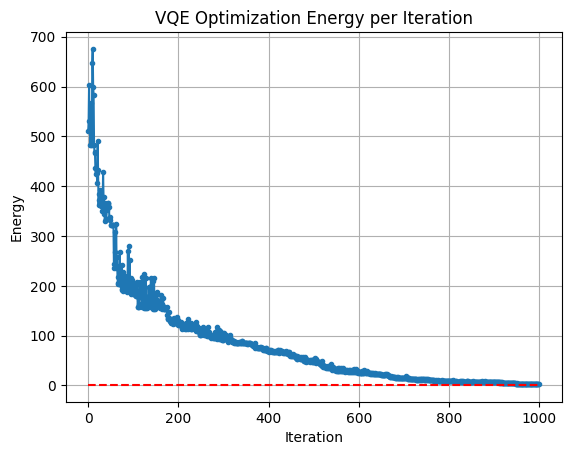

FOUND GLOBAL MINIMUM
ITERATION 2 === MUB VQE STATE (mub_idx=1, state_idx=0)
Ground state energy: 100.07562565707057
Optimal parameters: [-4.53590773e-04 -8.95449029e-01  2.05429101e+00  6.22955460e-04
  8.54263592e-04  8.93157275e-01 -4.25133608e-01  3.40649153e-01
 -3.11119770e-03 -3.30440484e-02 -3.36009103e-02  3.93425005e-02
 -2.25684682e-01  1.53210040e+00  6.96404029e-01  1.12708757e+00
  1.69329872e+00  4.91034309e-01  5.54305953e-02  2.48314094e+00
 -4.76512963e-05  1.96621078e-02  1.68029464e+00  2.65555623e-02
  2.75791823e-01  1.47074194e-01  2.20466384e-01  2.55594073e-01
  2.37077677e+00 -1.77499946e-01  1.55536227e+00  4.04951769e-01
  1.16070616e-04  9.12364857e-02  1.70217920e+00  4.86916261e-01
  1.54069713e+00 -1.39695902e-01  9.89245699e-01  4.82525425e-01
  7.18023323e-01  5.19030971e-01  4.43467766e-01  2.80295602e-01
 -4.65726042e-04 -1.04865395e-01  1.72968968e+00  1.94481590e-01
  1.55471180e+00  1.58037056e+00  1.04393122e+00  1.40637470e+00
 -3.50974923e-01  3

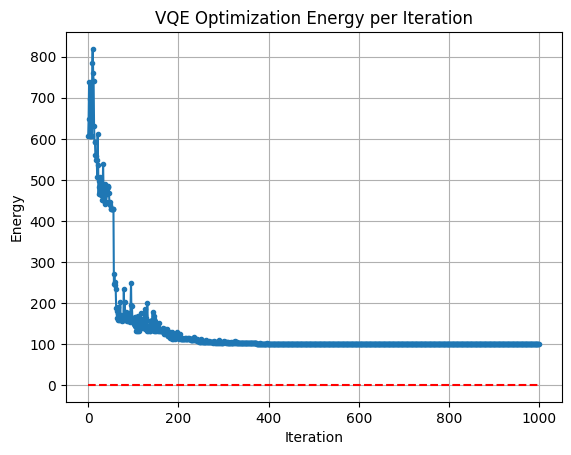

ITERATION 3 === MUB VQE STATE (mub_idx=1, state_idx=1)
Ground state energy: 2.593171540588536
Optimal parameters: [ 3.63589139e-01 -2.04934626e+00  2.72333466e+00 -4.68070950e-02
  2.79922798e+00  2.03600754e+00  5.57232602e-01  2.72129885e-01
  2.34827809e-02  9.20117361e-03  9.15309469e-01 -6.65945882e-03
  1.51312690e+00  1.39196214e+00  2.06252544e+00  1.34355047e+00
  1.47106255e+00  1.43928328e+00 -1.27190064e+00  2.07957736e+00
  1.15527378e-02 -5.53362060e-03 -3.09084472e-03 -3.48569312e-02
 -3.85665025e-01 -8.51881474e-02  5.88836793e-01  8.05078562e-01
  1.91511410e+00 -2.47540812e-01  1.34422712e+00  3.23138692e-02
 -1.57289919e-02  5.38864733e-03  9.15940491e-01  1.81130786e-02
  1.59387760e+00 -4.57525451e-01  1.48088932e-01 -3.27027163e-01
 -7.44203414e-02  8.34784414e-01  8.69162934e-01  8.69049604e-01
 -5.95433206e-03 -6.82466902e-03  1.59488815e-03  1.16647931e-03
  5.61618831e-02  1.81473905e+00  1.21031936e+00  1.30716218e+00
  1.05261890e+00  1.86322034e+00  1.27520

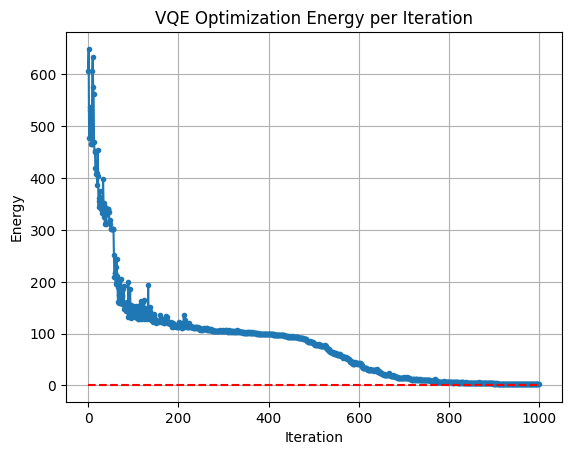

FOUND GLOBAL MINIMUM
===== SUCCESS RATE FOR GLOBAL MINIMUM 2/4=50.0%
ITERATION 20 === MUB VQE STATE on (np.int64(0), np.int64(6))
ITERATION 0 === MUB VQE STATE (mub_idx=0, state_idx=0)
Ground state energy: 100.0172841849336
Optimal parameters: [-8.21177441e-04 -6.35567644e-02 -5.64519678e-01  1.52012583e-01
 -8.34852283e-04  6.38608018e-02 -5.85854600e-02  5.08194208e-02
 -1.14083774e-03  1.79185412e+00  2.61133011e-03  1.57087468e-04
  7.88879639e-02  6.09968173e-01  2.40282966e+00  4.32583534e-01
  9.38826917e-01  5.64742853e-01  9.31659027e-01  2.09967301e+00
 -3.21697664e-03 -8.18570144e-01  2.11547239e+00  4.00964929e-03
  1.34846210e+00 -2.30107820e-01  1.21801314e+00  4.71541536e-01
  1.73225725e+00 -2.16495190e-02  2.27188436e+00  1.52354780e-02
 -1.26176634e-03  1.91972211e+00  7.69303621e-02  1.73734049e-01
  7.53326708e-01 -3.63237065e-01  4.43500949e-01  1.60417442e+00
  1.31584212e+00  2.23957507e+00  8.40360992e-01  1.13893097e-01
 -1.19234259e-04  1.10737062e-01  3.85689

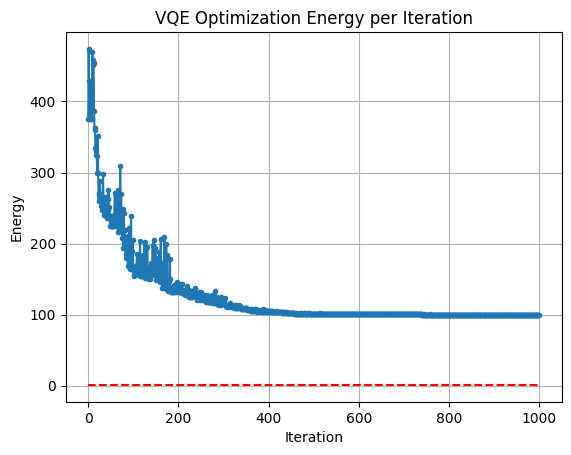

ITERATION 1 === MUB VQE STATE (mub_idx=0, state_idx=1)
Ground state energy: 1.676224281963687
Optimal parameters: [ 9.37640750e-03  9.07558013e-02  3.31388891e-01 -5.28778426e-01
  3.12469671e+00 -1.12362505e-01  1.10557808e+00  1.30195203e-01
  4.22187160e-03 -6.52789089e-03 -1.81831209e-03  2.24659897e-02
 -6.22407379e-02  1.11168037e+00  2.55633987e+00  1.97679662e+00
  1.24021062e+00  1.56933583e+00  1.14992799e+00  2.03107957e+00
  3.64620032e-03 -6.77086811e-04 -1.06831806e-02  2.69576671e-01
  1.26648056e+00 -2.28072473e-02  4.85043408e-01 -9.85962141e-02
  1.00907838e-01  2.67531025e-01  6.15220225e-01  1.68241648e+00
 -9.08950519e-03  2.53645316e-04 -1.35883342e-02  5.62226431e-01
  1.93327872e+00 -5.34061960e-01  1.71799137e+00  1.73731057e+00
  1.12640938e+00  1.65926017e-01  7.10224780e-01 -1.71866625e-01
  3.95401111e-03 -4.82745896e-03  1.90071146e-04  4.76731043e-01
  1.04523317e+00 -7.82075420e-01  2.94750853e+00  1.91544263e+00
  7.54132994e-01  1.72197894e-01 -1.35954

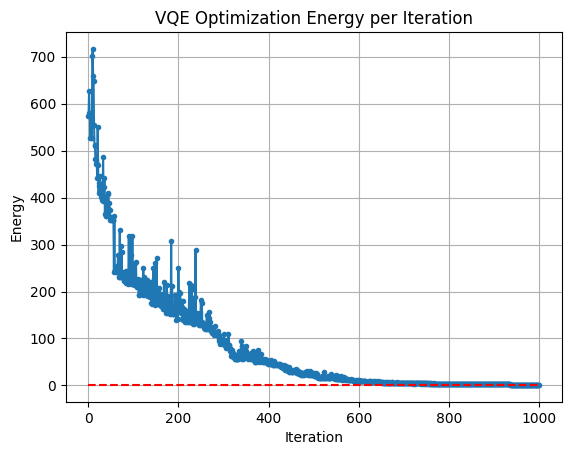

FOUND GLOBAL MINIMUM
ITERATION 2 === MUB VQE STATE (mub_idx=1, state_idx=0)
Ground state energy: 100.06006844809819
Optimal parameters: [-1.50789243e-01 -1.41435617e+00  3.04808908e+00  2.40446441e-03
  1.57654736e-01  1.41209364e+00 -2.66352998e-01  4.76995802e-02
 -5.93080167e-04 -1.23784270e-03  2.01003080e-01  2.34848633e-02
  8.23663915e-01  1.37803145e+00  1.35311115e+00  9.37183410e-01
  1.34161621e+00  7.35647805e-01  1.73999352e+00  2.28142211e+00
 -1.55461114e-02  2.16152465e-03  1.08230774e+00 -3.65449223e-01
  3.91486928e-01  1.03545817e-01  5.35304736e-01  1.89178301e-01
  1.94490127e+00 -2.11988874e-01  1.50043886e+00  2.45858542e-01
 -2.24730775e-03 -8.89424130e-04  1.81927966e-01 -3.00490513e-01
  2.57765797e+00 -5.19251655e-01  1.64495762e+00  8.66681045e-01
  4.11314767e-01  7.27880847e-01  6.04769793e-01  5.71843907e-01
 -1.29916467e-02  1.39930933e-03  2.08068536e+00  6.73768263e-01
  8.66437196e-01  1.49517056e+00 -4.55184422e-01  7.24530686e-01
 -7.89061841e-02  5

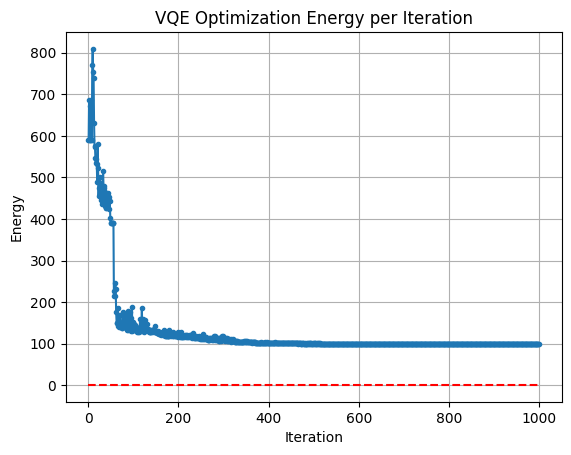

ITERATION 3 === MUB VQE STATE (mub_idx=1, state_idx=1)
Ground state energy: 100.13688733444563
Optimal parameters: [-3.66861570e-03 -3.03863152e+00 -6.60564548e-01 -3.22477124e-01
  5.44832699e-03  3.03526596e+00 -1.07694101e+00  1.33152601e+00
 -1.67751122e-03 -4.36954158e-03  1.34860838e+00  7.19627148e-01
  8.08889602e-02  1.86719043e+00  1.50909571e+00  5.80494111e-01
  2.20977261e+00  3.79537788e-01  2.13310199e+00  2.54408245e+00
  3.38453613e-03  1.33610201e-01  9.65650695e-01 -4.00550316e-01
  5.09638141e-01  3.48333258e-01  5.46656876e-01  3.93820342e-01
  1.84061985e+00  1.31282628e-01  1.17857615e+00  5.63707760e-01
 -1.00254290e-05  2.87616714e-01  1.32920122e+00  1.48112576e+00
  1.70712312e+00 -1.10624329e-02 -1.03846056e+00 -8.96591237e-02
 -1.16669888e-01  8.08424812e-01  1.00660192e+00  3.07314997e-02
  4.62362956e-03  3.87691126e-02  5.58318090e-01 -6.68906727e-01
  1.06765700e+00  1.60666373e+00  8.02826667e-01  3.48354530e-01
  3.71556105e-01  2.12362087e+00 -2.0853

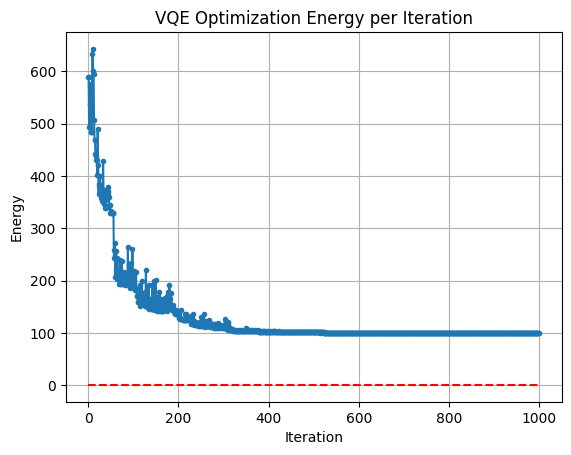

===== SUCCESS RATE FOR GLOBAL MINIMUM 1/4=25.0%
ITERATION 24 === MUB VQE STATE on (np.int64(0), np.int64(7))
ITERATION 0 === MUB VQE STATE (mub_idx=0, state_idx=0)
Ground state energy: 100.03341524006355
Optimal parameters: [-2.34244280e-03 -1.08698281e-04  1.74760467e+00  6.31112446e-01
  3.83705961e-03  7.80964017e-05 -1.91966568e-01  1.71737314e-01
 -1.75554520e-03 -1.19558039e-02 -1.79446125e-01  1.03456036e-02
  1.42629810e+00  1.56132523e+00  1.69990845e+00  8.54161169e-01
  1.63869481e+00  1.69807886e+00  3.51419956e-01  2.24304491e+00
 -2.89082031e-03 -3.69257878e-02  1.24346809e+00  1.42720044e+00
  2.78970270e-01  8.17527856e-03  6.94318422e-01  1.05128253e+00
  2.86890937e-01  3.05452205e-01  1.67701562e+00 -5.08647136e-02
 -2.11471154e-04  4.92997845e-02  5.84584337e-01  1.50096411e+00
  1.45714661e+00 -1.94700299e-02  1.73143529e+00  2.04638893e-01
 -8.69276047e-01  1.85049614e+00  7.23384856e-01  8.93648493e-01
 -6.84664796e-04 -3.64566651e-02  1.78858742e+00  7.64673728e

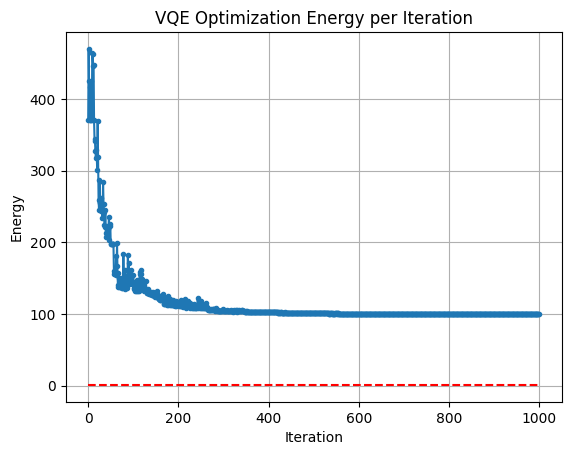

ITERATION 1 === MUB VQE STATE (mub_idx=0, state_idx=1)
Ground state energy: 45.15352261157335
Optimal parameters: [-5.34301439e-02  5.78226961e-01  1.32454499e+00  1.04951757e+00
  3.22458544e+00  2.29989789e-01  6.30472545e-01 -5.41867285e-01
 -1.55139379e-03  1.71458800e-02 -1.15650681e-02  1.02111685e-01
 -6.01149177e-01  1.23796625e+00  2.31446666e+00  1.20240980e-01
  9.64066258e-01 -2.41294531e-01 -5.88223728e-02  2.72058895e+00
  3.15999673e-02  1.11116862e-01  1.51739387e+00 -8.43125131e-02
  8.64899958e-01  1.08889576e+00  1.15103971e+00  1.12099551e+00
 -5.26661096e-02  8.57590845e-01  6.27742848e-01 -2.46253670e-02
 -9.36182636e-02  9.11436147e-01  1.60145192e+00  1.55413540e+00
  2.10307719e+00 -7.11181780e-01  1.29280117e+00  7.74101617e-02
 -8.64522112e-02  7.51824101e-02  8.60454260e-01  8.10065430e-01
 -2.22115172e-02  8.82066169e-01  1.25525334e+00  3.23364459e-02
  1.61500760e+00  5.55890141e-01 -8.65702451e-01 -3.58758651e-02
  1.81491078e+00  2.41375474e-01  4.64186

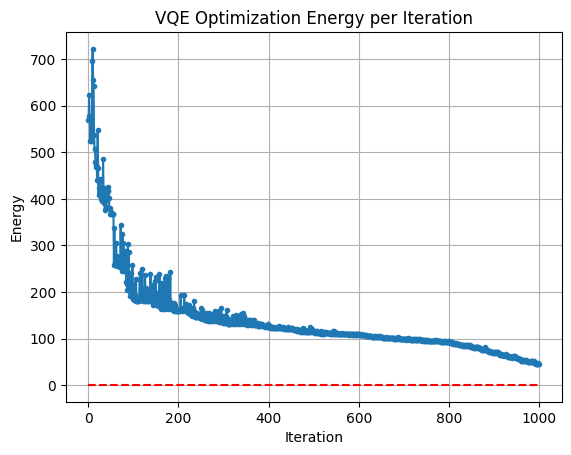

ITERATION 2 === MUB VQE STATE (mub_idx=1, state_idx=0)
Ground state energy: 100.03085657279476
Optimal parameters: [ 1.17534180e-02 -8.22897862e-01  9.77488008e-02 -2.83261710e-03
  1.12112399e-02  8.21458774e-01 -1.41728834e+00  5.39352569e-01
 -1.54754371e-03  1.25257126e-02  8.41914443e-01 -5.31699814e-03
 -3.76540657e-01  9.29709154e-01  7.97578775e-01  3.39562892e-01
  1.38901822e+00  3.67115179e-01  3.39824084e-01  2.53744574e+00
 -2.16878255e-03  1.48300120e-04  1.44510789e+00 -1.62209002e-01
 -2.86084053e-02  1.33852443e-01  2.56483072e-01  9.28734353e-01
  2.09305425e+00  1.63417897e-01  1.05301440e+00  5.88857403e-01
  1.55790761e-03 -5.23738516e-02  1.17964245e+00  1.16847319e+00
  1.51349943e+00 -7.46975616e-01  3.98354213e-01  9.16809044e-01
  8.96197534e-01  9.92850889e-01  7.23897376e-01  7.75347391e-02
  7.21707049e-04  5.67951873e-02  1.74032833e+00 -3.91829644e-02
  1.20744928e+00  1.72047877e+00  1.18994756e+00  9.83601228e-01
  1.65475520e+00  1.96840148e-01  2.5077

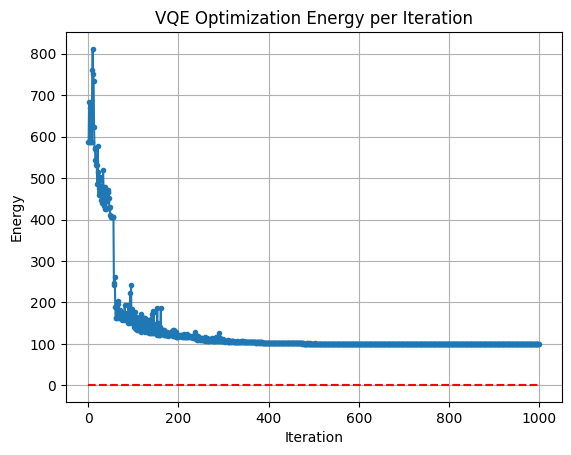

ITERATION 3 === MUB VQE STATE (mub_idx=1, state_idx=1)
Ground state energy: 100.0353724641279
Optimal parameters: [ 8.59508202e-01 -1.56897843e+00 -2.47071728e-03  3.56731624e-03
  8.59342732e-01  1.56861571e+00 -6.39470097e-01 -1.69833526e-01
 -9.32619137e-05 -2.28245160e-03  7.74064172e-01  2.70203163e-02
  4.17401111e-01  1.28086031e+00  8.93514067e-01  2.67500393e+00
  5.08837486e-01  7.89163581e-01 -4.02852376e-01  1.99295815e+00
  3.55840852e-04 -4.12743950e-04  1.42942604e+00  9.65208739e-02
 -6.93969469e-01 -9.64513483e-02  8.00781214e-01  2.22467679e+00
  1.46247309e+00  4.30133700e-01  8.93853009e-01  8.99189362e-01
 -3.07048333e-04  2.72839670e-05  3.62570590e-01  8.36460837e-01
  1.99702525e+00 -3.95182211e-01  1.77706732e+00  1.47908611e+00
  5.37700309e-01  6.77288341e-01  6.61240644e-01  3.63781058e-01
  1.34088180e-03 -5.34559458e-03  1.05479055e+00 -6.88258765e-02
  8.62473628e-01  1.46464335e+00 -2.26449969e-01  1.71720025e+00
  8.12269743e-01  7.55164139e-01  5.97771

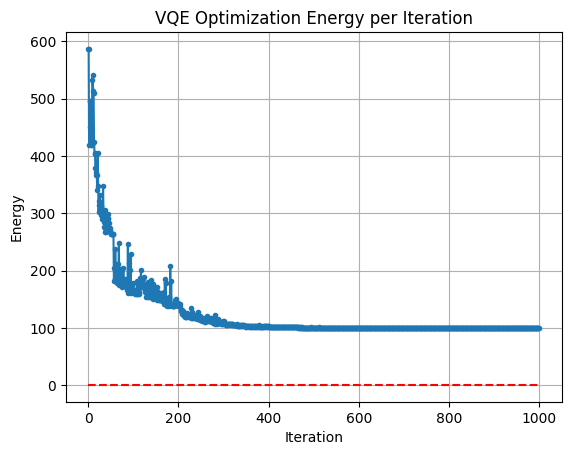

===== SUCCESS RATE FOR GLOBAL MINIMUM 0/4=0.0%
ITERATION 28 === MUB VQE STATE on (np.int64(1), np.int64(2))
ITERATION 0 === MUB VQE STATE (mub_idx=0, state_idx=0)
Ground state energy: 100.21678220089116
Optimal parameters: [ 2.48826838e-03 -2.41930106e-01  8.74824892e-01 -2.32774183e-01
 -3.88692048e-04  2.51611322e-01 -8.94666905e-02 -3.38552076e-01
  2.87543329e-02  1.58818042e+00  2.84507211e-03  9.70574933e-03
 -4.97944290e-02  1.33481845e+00  7.95221800e-01  6.77187280e-01
  1.92969884e+00  4.12992683e-01  1.52223298e+00  8.87956984e-01
  2.37678176e-01 -2.50158509e-01  1.37542363e+00  3.64850636e-03
  1.03277552e+00  3.02740939e-01 -1.53579301e-01  2.37674876e-01
  1.97530567e+00  8.48874695e-01  1.61447415e+00  1.41205701e+00
  6.02849913e-03  1.35995686e+00 -2.12364442e-01  8.63990462e-01
  1.50172871e+00  2.05332411e-02  1.66363431e+00  1.15764972e+00
  7.22119445e-05  8.11899528e-01  8.09128497e-01  5.45127906e-01
  2.33238410e-01 -1.15708297e-01  7.44205296e-01 -4.99238672e-

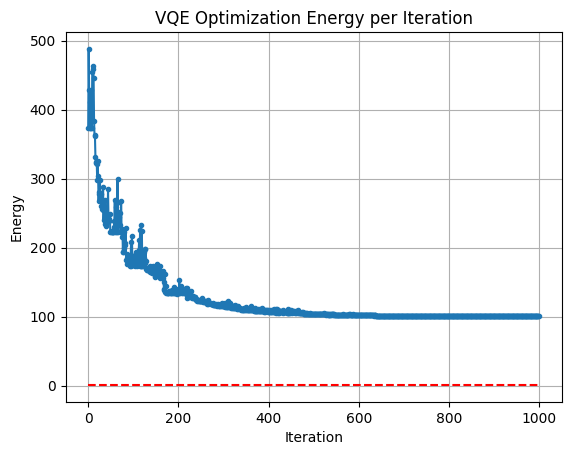

ITERATION 1 === MUB VQE STATE (mub_idx=0, state_idx=1)
Ground state energy: 1.4215208552997103
Optimal parameters: [-1.52946717e-01  1.03700530e+00  1.74502693e-01 -4.48715412e-03
  3.31780325e+00 -1.04155682e+00  1.93902201e+00 -1.98146062e-01
 -1.72385223e-03  4.51784100e-03  3.55425868e-03  9.42849833e-03
  3.85650542e-01  4.93313643e-01  2.39753320e+00  1.30554161e+00
  3.23575667e+00  6.86369319e-01 -1.52418996e+00  2.03226881e+00
 -5.23483029e-03 -9.22352709e-04 -5.06736709e-04  1.07706181e-02
 -7.83405562e-01  9.15345479e-01  8.50110745e-01 -5.66543017e-02
 -5.24837245e-01  1.51773558e+00 -1.02819611e-01  1.61440914e+00
 -4.87801911e-03 -5.98201143e-03 -3.64859555e-04 -7.02401380e-03
  2.17767534e+00 -1.77627237e-01  1.15749315e+00  1.05918975e+00
 -1.25890831e+00  2.15573984e+00  1.49037110e+00  7.22413049e-01
  1.13756869e-02  5.74538833e-03 -2.83062210e-03  7.32802643e-03
  1.18137176e-01  2.09781356e+00  1.66983155e-01  1.97308687e+00
  1.16844007e+00  1.54868364e+00 -2.6347

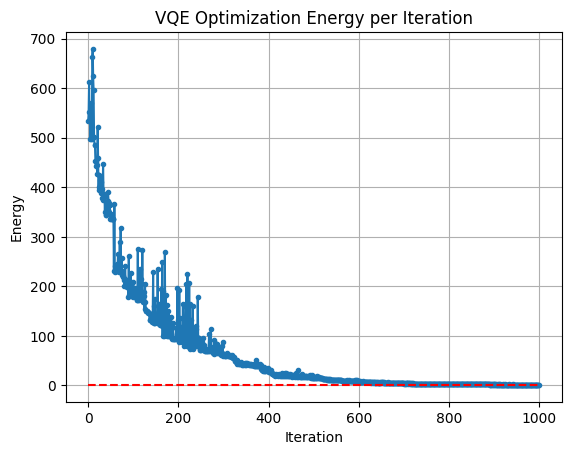

FOUND GLOBAL MINIMUM
ITERATION 2 === MUB VQE STATE (mub_idx=1, state_idx=0)
Ground state energy: 100.11470030420335
Optimal parameters: [-7.04335993e-04 -1.07923661e+00  5.72633874e-01 -1.73201020e-01
 -3.43294927e-03  1.17887744e+00  9.86169954e-01 -9.61813800e-01
  1.96146809e-03  4.76639554e-01  3.75038530e-02  1.50252711e+00
 -3.48917680e-02  1.65964968e+00  1.65815241e+00  1.92206019e+00
  1.84481859e+00  7.14626347e-01 -2.23275244e-01  1.79067551e+00
 -5.38246743e-03  2.87198321e-01  1.70605314e+00  3.15502520e-01
  1.01346091e+00  3.87475392e-01  1.35226023e+00  3.78168819e-01
  1.91129974e+00  7.32983532e-01  1.87642214e+00  1.32924104e+00
  1.25574234e-03  5.17234915e-01  2.41503970e-01  8.09348148e-01
  1.69320478e+00  6.57447194e-03  1.56871778e+00  1.74227835e+00
  5.88950135e-01  1.49152390e+00  7.63265214e-01  2.94368397e-02
  1.06844140e-03 -1.27888501e-01  9.91591124e-01  7.57422544e-01
  1.46976224e+00  1.58180265e+00  4.62483964e-01  9.88699383e-01
  1.46167989e+00 -1

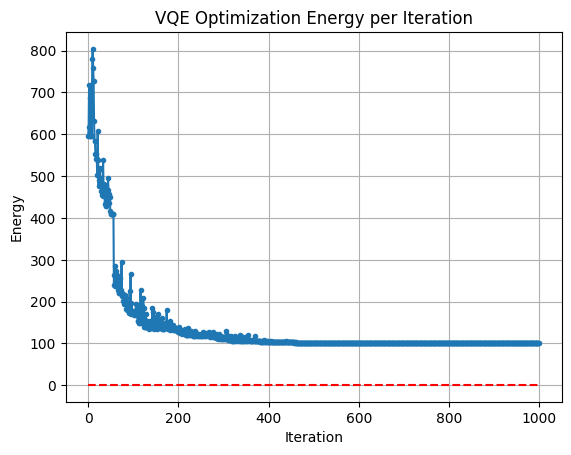

ITERATION 3 === MUB VQE STATE (mub_idx=1, state_idx=1)
Ground state energy: 1.158228712158438
Optimal parameters: [-2.22841918e-03 -3.15305764e+00  6.93246196e-01 -5.72503197e-01
  2.49032138e-03  3.16298169e+00  1.32315995e+00 -8.57619708e-01
 -5.72646363e-04  1.00972581e-03  6.92650797e-04  3.39032265e-03
 -4.45096930e-01  1.22518347e+00  1.93539994e+00  1.25043028e+00
  6.16576031e-01  1.73597079e+00  2.42310808e-01  1.83926180e+00
  1.69890181e+00 -1.02807659e-03  1.57027268e+00 -6.25421653e-03
 -8.59162605e-01 -1.64317701e-01  2.37899080e-02  2.36407404e-01
  1.26780874e+00 -9.65954438e-01  1.99196108e+00  6.06153294e-01
  4.24405350e-01  4.25119536e-01 -5.28769819e-03  8.57727947e-03
  1.63448932e+00 -2.88951536e-01  1.12164805e+00  2.00162668e+00
 -2.68886043e-01  2.14029540e+00  2.63003210e+00  2.31576673e-01
  1.44777337e+00  1.57683666e-02  1.56581348e+00 -1.11904620e-03
  1.56430160e+00  2.28282253e+00  9.20137824e-02  2.11959569e+00
  3.23798116e-01  1.64932470e+00  5.79523

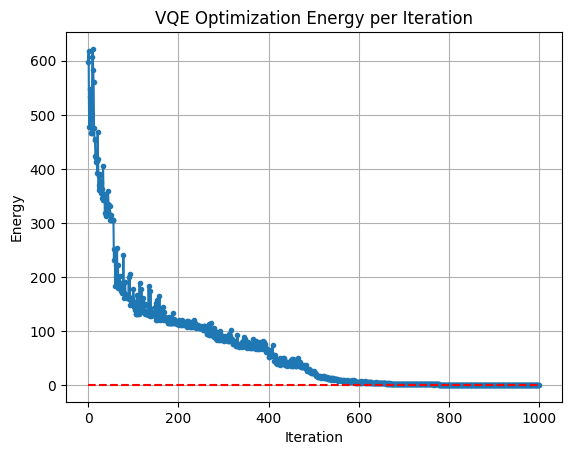

FOUND GLOBAL MINIMUM
===== SUCCESS RATE FOR GLOBAL MINIMUM 2/4=50.0%
===== TOTAL SUCCESS RATE FOR GLOBAL MINIMUM 9/32=28.125%


(9, 32)

In [12]:
from experiment_utils import *

run_VQE_MUB_for_all_choose_2q(H_total_JSP, min_eigenvalue.real, 30, list(itertools.product(range(2), range(2))))

In [1]:
# from experiment_utils import *
# from qiskit_aer import Aer

# #Test that this is the MUB state:
# ansatz, thetas = get_mub_ansatz_and_thetas(8, state_idx=1, mub_idx=4, MUB_mask=None)

# qc = ansatz.assign_parameters(thetas)
# print(qc)
#print(parameter_dict_to_list(thetas, ansatz))
##

# # Simulate the circuit
# # backend = Aer.get_backend('statevector_simulator')
# # job = backend.run(qc)
# # result = job.result()
# # statevector = result.get_statevector()

In [2]:
# def vector_to_spherical_angles(v):
#     # Ensure the input is a numpy array and normalized
#     v = np.asarray(v)
#     assert np.isclose(np.linalg.norm(v), 1), f"The vector {v} must be normalized."
    
#     n = len(v)
#     angles = np.zeros(n - 1)

#     # Calculate the angles
#     for i in range(0, n - 1):
#         # Calculate the angle theta_i
#         # Use the norm of the remaining dimensions
#         norm_remaining = np.linalg.norm(v[i+1:])
#         angles[i] = np.arctan2(norm_remaining, v[i])
    
#     return angles

# def spherical_angles_to_vector(angles):
#     # Ensure the input is a numpy array
#     angles = np.asarray(angles)
#     n = len(angles) + 1  # Number of dimensions
    
#     # Initialize the unit vector
#     v = np.zeros(n)
    
#     # Calculate the first coordinate
#     v[0] = np.cos(angles[0])
    
#     # Calculate the remaining coordinates
#     for i in range(1, n):
#         # Compute the product of sines for the previous angles
#         if i < n - 1:
#             sin_product = np.prod(np.sin(angles[:i]))  # Product of sines for angles up to i-1
#             v[i] = sin_product * np.cos(angles[i])
#         else:
#             # For the last coordinate, we use the product of sines for all previous angles
#             v[i] = np.prod(np.sin(angles[:i]))  # This is sin(theta_1) * sin(theta_2) * ... * sin(theta_{n-2})

#     return v

# test_v = np.array([1/np.sqrt(5),1/np.sqrt(2),1/np.sqrt(10/3)])
# print(vector_to_spherical_angles(test_v))
# print(np.isclose(spherical_angles_to_vector(vector_to_spherical_angles(test_v)), test_v))

# def get_directions(v, step_size):
#     # Ensure the input is a numpy array
#     v = np.asarray(v)
#     directions = []
    
#     # Iterate over each element in the vector
#     for i in range(len(v)):
#         # Create a copy of the original vector
#         v_plus = v.copy()
#         v_minus = v.copy()
        
#         # Modify the i-th element
#         v_plus[i] += step_size
#         v_minus[i] -= step_size
        
#         # Append the new vectors to the directions list
#         directions.append(v_plus)
#         directions.append(v_minus)
    
#     return directions

# def optimizer(H, initial_guess, step_size=0.01):
#     best_vector_angles = vector_to_spherical_angles(initial_guess)
#     print(best_vector_angles)
#     best_value = get_eigenvalue_sparse(initial_guess, H)
#     print(best_value)
    
#     for iterations in range(500):
#         #Pick best direction
#         for nearby_step in get_directions(best_vector_angles, step_size):
#             new_value = get_eigenvalue_sparse(spherical_angles_to_vector(nearby_step), H)
#             print("direction")
#             if(best_value > new_value):
#                 best_value = new_value
#                 best_vector_angles = nearby_step
#         print(best_vector_angles)
    
#     return best_value, spherical_angles_to_vector(best_vector_angles)

In [3]:
# from scipy.sparse import diags

# H_diag_sparse = diags(H_diag.reshape(-1,))
# initial = np.zeros(shape=(H_diag.shape[0],))
# initial[0] = 1

# optimizer(H_diag, initial)

In [4]:
# **Quantum Exhaustive Binary Search - QEBS**
# from hamiltonians import get_expectation_value
# from qiskit.quantum_info import Statevector

# state_string = "+" * task.num_qubits

# for i in range(task.num_qubits):
#     #If 0
#     state_string_if_0 = state_string[:i] + "0" + state_string[i+1:]
#     state_if_0 = initialize_state_from_string(state_string_if_0)
#     #If 1
#     state_string_if_1 = state_string[:i] + "1" + state_string[i+1:]
#     state_if_1 = initialize_state_from_string(state_string_if_1)
#     print(get_expectation_value(state_if_0, H_total_JSP), get_expectation_value(state_if_1, H_total_JSP))
#     if get_expectation_value(state_if_0, H_total_JSP) >= get_expectation_value(state_if_1, H_total_JSP):
#         state_string = state_string_if_1
#     else:
#         state_string = state_string_if_0

# final_state = initialize_state_from_string(state_string)

# print("Naive solution", state_string)

In [ ]:
# **Simulated Annealing binary search**
# def simulated_annealing_binary_search(hamiltonian, n, max_iterations, debug=True):
#     # Initialize an empty prefix and a dictionary to track prefixes and their values
#     prefixes = {"":1}
#     best_solution = None
#     best_solution_value = 1e9

#     average_value = get_expectation_value(initialize_state_from_string("+" * n), hamiltonian)

#     for _ in range(max_iterations):
#         if len(prefixes) == 0:
#             break

#         # Sample a prefix with probability proportional to exp(-value(prefix))
#         total_value = sum(np.exp(-value / average_value) for value in prefixes.values())
#         probabilities = [np.exp(-value / average_value) / total_value for value in prefixes.values()]
        
#         # Sample a prefix based on the calculated probabilities
#         sampled_prefix = np.random.choice(list(prefixes.keys()), p=probabilities)
#         print(f"Sampled {sampled_prefix}") if debug else None
#         del prefixes[sampled_prefix]

#         # Check the value of adding a '0' to the sampled prefix
#         prefix_with_zero = sampled_prefix + "0" + "+" * (n-len(sampled_prefix)-1)
#         if len(sampled_prefix) + 1 < n:
#             prefixes[sampled_prefix + "0"] = get_expectation_value(initialize_state_from_string(prefix_with_zero), hamiltonian)
#         elif get_expectation_value(initialize_state_from_string(prefix_with_zero), hamiltonian) < best_solution_value:
#             best_solution_value = get_expectation_value(initialize_state_from_string(prefix_with_zero), hamiltonian)
#             best_solution = sampled_prefix + "0"
#             print(f"Landed on final state {best_solution}") if debug else None

#         # Check the value of adding a '1' to the sampled prefix
#         prefix_with_one = sampled_prefix + "1" + "+" * (n-len(sampled_prefix)-1)
#         if len(sampled_prefix) + 1 < n:
#             prefixes[sampled_prefix + "1"] = get_expectation_value(initialize_state_from_string(prefix_with_one), hamiltonian)
#         elif get_expectation_value(initialize_state_from_string(prefix_with_one), hamiltonian) < best_solution_value:
#             best_solution_value = get_expectation_value(initialize_state_from_string(prefix_with_one), hamiltonian)
#             best_solution = sampled_prefix + "1"
#             print(f"Landed on final state {best_solution}") if debug else None

#         print(prefixes) if debug else None
#         #print("normalized", [(k, prefixes[k] / average_value) for k in prefixes.keys()])

#     # Return the most valuable prefix or any other relevant information
#     if best_solution == None or (len(prefixes) > 0 and best_solution_value > min(prefixes.values())):
#         proposed_solution = min(prefixes, key=prefixes.get)
#     else:
#         proposed_solution = best_solution
    

#     if len(proposed_solution) < n:
#         for _ in range(n - len(proposed_solution)):
#             values, keys = np.array(list(prefixes.values())), np.array(list(prefixes.keys()))
#             sampled_prefix = keys[np.argmin(values)]

#             print(f"Greedy Sampled {sampled_prefix}") if debug else None
#             del prefixes[sampled_prefix]

#             # Check the value of adding a '0' to the sampled prefix
#             prefix_with_zero = sampled_prefix + "0" + "+" * (n-len(sampled_prefix)-1)
#             prefix_with_zero_value = get_expectation_value(initialize_state_from_string(prefix_with_zero), hamiltonian)
#             if len(sampled_prefix) + 1 < n:
#                 prefixes[sampled_prefix + "0"] = prefix_with_zero_value
            
#             # Check the value of adding a '1' to the sampled prefix
#             prefix_with_one = sampled_prefix + "1" + "+" * (n-len(sampled_prefix)-1)
#             prefix_with_one_value = get_expectation_value(initialize_state_from_string(prefix_with_one), hamiltonian)
#             if len(sampled_prefix) + 1 < n:
#                 prefixes[sampled_prefix + "1"] = prefix_with_one_value

#             if len(sampled_prefix) + 1 == n:
#                 if prefix_with_zero_value < prefix_with_one_value:
#                     return sampled_prefix + "0"
#                 else:
#                     return sampled_prefix + "1"

#             print("Greedy", prefixes) if debug else None
#             #print("Greedy normalized", [(k, prefixes[k] / average_value) for k in prefixes.keys()])
#     else:
#         return proposed_solution

# print("Found Solution", simulated_annealing_binary_search(H_total_JSP, task.num_qubits, 4))

In [ ]:
#**Benchmark - Probability of success vs number of iterations**
# N_MAX = 20
# iter_nums = list(range(2, 6))
# probabilities = []

# for iter_num in iter_nums:
#     success = 0
#     for N in range(N_MAX):
#         if simulated_annealing_binary_search(H_total_JSP, task.num_qubits, iter_num, debug=False) == binary_solution:
#             success += 1
#     probabilities += [success / N_MAX]

# print(probabilities)
# plt.plot(iter_nums, probabilities, marker='.')
# plt.xlabel("Number of Iterations")
# plt.ylabel("Probability of finding the optimal solution")

# plt.show()